<a href="https://colab.research.google.com/github/aburchell/pollack-notebooks/blob/main/pollack_tone_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting things up

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import glob
import math
import random
import re
from plotnine import ggplot, aes, geom_density, geom_histogram, facet_wrap, geom_bar, geom_point, xlab, ylab, ggtitle, qplot, coord_fixed, geom_jitter, facet_grid, facet_wrap, geom_abline, geom_line, geom_errorbar
from plotnine.options import set_option
from plotnine.scales import scale_color_brewer, scale_color_manual
from plotnine.themes import theme, element_rect, element_line, themeable
from plotnine.labels import labs
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from io import StringIO
import pandas as pd
import numpy as np
from numpy import std
import altair as alt
import sklearn as skl
import scipy as spy

In [ ]:
%matplotlib inline

In [ ]:
include_training_data = False
large_run = False

In [ ]:
niceblue = '#0088CD'
nicemagenta = '#C50060'
niceyellow = '#FFEF0F'
nicelighttan = '#D4BB65'
nicelightyellow = '#D8D566'

## Load in data
No more having to authorize drive access! Yay!

Data tidy'ed here: https://colab.research.google.com/drive/1kIQIYVrWs5yqWFz3GGMsA21Hzt8QiPUH?usp=sharing

In [ ]:
def df_from_drive(url):
  # https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
  # url = 'https://drive.google.com/file/d/1nVzvg1Z9SqXhcQNc7IcdF8-uHtlFf_wH/view?usp=sharing'
  path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
  return pd.read_csv(path)

In [ ]:
response_url = 'https://drive.google.com/file/d/1nVzvg1Z9SqXhcQNc7IcdF8-uHtlFf_wH/view?usp=sharing'
response_df = df_from_drive(response_url)

# Performance across block number




In [ ]:
response_df.replace(to_replace=['True', 'False', '1.0', '0.0'], value=[1,0,1,0], inplace=True)
response_df.astype({'correct': int})

,Unnamed: 0,sender,sender_type,sender_id,timestamp,Unnamed: 5,confidence,consent,correct,correctResponse,debrief,desired_repetitions_per_tone,duration,ended_on,experience,headphone,ntones,pitch,response,response_action,time_commit,time_end,time_render,time_run,time_show,time_switch,tone_id,url,pid,source_file_id,block_id,index,Unnamed: 32,block_sender_id
0,0,Get response,html.Page,1_3_0_2_0_1,2021-01-25T21:38:05.127Z,NaN,6,NaN,0,3,NaN,7.0,2582.226,response,0,yes,6,no,5,click button#button5,167381.085,167355.340,164756.030,164907.230,164773.114,167241.279,3.0,NaN,AF,0,NaN,NaN,NaN,1
1,1,Get response,html.Page,1_3_0_2_1_1,2021-01-25T21:38:11.430Z,NaN,6,NaN,0,6,NaN,7.0,918.365,response,0,yes,6,no,5,click button#button5,173683.175,173680.945,172745.827,172898.290,172762.580,173563.152,6.0,NaN,AF,0,NaN,NaN,NaN,1
2,2,Get response,html.Page,1_3_0_2_3_1,2021-01-25T21:38:16.448Z,NaN,6,NaN,1,1,NaN,7.0,1032.596,response,0,yes,6,no,1,click button#button1,178702.065,178699.915,177824.750,177826.500,177667.319,178567.329,1.0,NaN,AF,0,NaN,NaN,NaN,1
3,3,Get response,html.Page,1_3_0_2_5_1,2021-01-25T21:38:21.777Z,NaN,6,NaN,0,5,NaN,7.0,1407.960,response,0,yes,6,no,3,click button#button3,184031.125,184028.770,182604.010,182755.785,182620.810,183888.477,5.0,NaN,AF,0,NaN,NaN,NaN,1
4,4,Get response,html.Page,1_3_0_2_6_1,2021-01-25T21:38:27.527Z,NaN,6,NaN,1,4,NaN,7.0,1453.635,response,0,yes,6,no,4,click button#button4,189781.830,189779.845,188483.420,188485.035,188326.210,189660.637,4.0,NaN,AF,0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6832,6832,Get response,html.Page,2381651.0,2021-03-25 06:13:16.665000+00:00,NaN,3,NaN,1,1,NaN,5.0,334.868,response,0,yes,6,no,1,click button#button1,1641236.785,1641235.620,1640884.039,1640885.730,1640900.752,1641250.876,1.0,NaN,662,j_5,8.0,2236.0,NaN,9
6833,6833,Get response,html.Page,2381661.0,2021-03-25 06:13:21.225000+00:00,NaN,3,NaN,1,4,NaN,5.0,626.717,response,0,yes,6,no,4,click button#button4,1645796.890,1645795.780,1645152.341,1645154.165,1645169.063,1645802.612,4.0,NaN,662,j_5,8.0,2242.0,NaN,9
6834,6834,Get response,html.Page,2381701.0,2021-03-25 06:13:25.560000+00:00,NaN,3,NaN,1,2,NaN,5.0,377.116,response,0,yes,6,no,2,click button#button2,1650132.385,1650131.245,1649737.400,1649738.995,1649754.129,1650137.492,2.0,NaN,662,j_5,8.0,2251.0,NaN,9
6835,6835,Get response,html.Page,2381741.0,2021-03-25 06:13:29.905000+00:00,NaN,3,NaN,1,3,NaN,5.0,386.541,response,0,yes,6,no,3,click button#button3,1654476.885,1654475.655,1654072.409,1654074.180,1654089.114,1654489.152,3.0,NaN,662,j_5,8.0,2260.0,NaN,9


In [ ]:
by_block = response_df.groupby(['block_sender_id','pid']).agg({'correct': 'sum'}).reset_index()

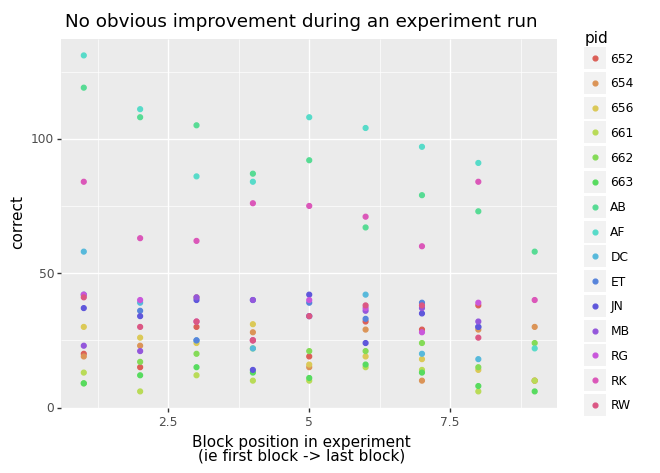

<ggplot: (8772302050369)>

In [ ]:
(ggplot(by_block, aes(x='block_sender_id'))
  #+ geom_bar(response_df[response_df['correct'] == True])
  + geom_point(aes(color='pid', y='correct'))
  + xlab("Block position in experiment\n(ie first block -> last block)")
  + ggtitle("No obvious improvement during an experiment run")
)

In [ ]:
# Can the block position in the experiment predict whether they will get it right?
block_num_model = spy.stats.linregress(by_block['block_sender_id'], by_block['correct'])
# r, p
block_num_model[2], block_num_model[3]
# Nope, but it's getting closer

(-0.13189453388728103, 0.13623204530682878)

# Omit poor performing observers

## TODO automate (ie not hard-coded) this, to use cross-correlation strength as criteria

ie only those observers for whom the normalized cross-correlation strength
between response and stimuli is less than 0.8

In [ ]:
bad_observers = ['661', '663'] # TODO automate this
response_df = response_df[~response_df['pid'].isin(bad_observers)]

# Omitting training

In [ ]:
if not include_training_data:
  response_df = response_df.groupby(['pid', 'ntones', 'block_sender_id']).apply(lambda group: group.iloc[10:]).drop(columns=['ntones', 'pid', 'block_sender_id']).reset_index()
  response_df.name = 'trained responses'
else:
  trained_df = response_df.groupby(['pid', 'ntones', 'block_sender_id']).apply(lambda group: group.iloc[10:]).drop(columns=['ntones', 'pid', 'block_sender_id']).reset_index()
  trained_df.name = 'trained responses'


# Looking at mutual information

We want to look at the amount of information in the source, ie log_2 of the number of tones in the block, vs the mutual information, ie the mutual information between the correct toneIDs and the guessed toneIDs (in base 2).

We need to do this analysis on the block level, that is each block condition, ie each unique value of ntones, should give us one data point, ie value for source info and value for mutual info. This is what each point in one of the characteristic Miller graphs represent.

We will further group this ntones-grouped data by participant, such that we get a single point for reach block-condition for each participant. We can then summarize the population's performance by averaging all particants' mutual information for each block (ie average over participants, within block).

## Calculate mutual information

In [ ]:
# Our bespoke implementation
"""
Compute mutual information and other relevant information metrics for two random variables.
"""

__author__ = "Augustin Burchell, Hörmet Yiltiz"
__copyright__ = "Copyright (C) 2021 Hörmet Yiltiz"
__license__ = "GNU GPL version 3 or later"
__version__ = "0.9"

from itertools import product
import numpy as np

# TODO: add `hypothesis` property tests for mutual information and entropy


def compute(X: list, Y: list, domain: list):
    """Computes the mutual information between two random variables, defined as:
    sum pXY log(pXY/(pX pY)) in bits. Returns a tuple that contains:
      - mutual information
      - mutual information normalized by the entropy of X (useful if X is
        signal)
      - a nested dictionary that contains other normalized variants of mutual
        information, as well as some commonly used information theoretic
        metrics such as entropy, conditional entropy, self-information (also
        known as information content or surprisal), relative entropy (also
        known as KL-divergence or information gain). Joint and marginal
        probability mass functions and contingency tables are also included for
        convenience.
    Copyright (C) Hörmet Yiltiz <hyiltiz@gmail.com>, 2021.
    """
    # TODO generalize for N variables; currently it assumes the X and Y are in
    # the same encoding/dictionary/domain generalize the input arguments s.t.
    # it works for ND vectors, like:
    # compute_mutual_information([X, Y, ...],
    #                            [(range(of X)),(domain of Y),...])

    observed = list(zip(X, Y))
    N = len(observed)

    # NOTE: range() upper range is larger by 1
    grid = product(range(domain[0][0], domain[0][1]+1),
                   range(domain[0][0], domain[0][1]+1))

    # compute the joint frequency table
    observed_counts = [observed.count(coord) for coord in grid]
    cXY = np.array(observed_counts).reshape(domain[0][1], domain[1][1])

    # compute the marginal counts
    [cX, cY] = np.meshgrid(cXY.sum(axis=0), cXY.sum(axis=1))

    # now normalize into probability mass functions
    [pXY, pX, pY] = [cXY/N, cX/N, cY/N]
    pXpY = pX * pY

    # get rid of the zero events (only in the joint is sufficient)
    # 0 * log(0/[possibly zero]) := 0 for information
    # this limit actually comes from the expectation definition of information
    nonzeros = pXY != 0
    nonzeros_X = pX[0, :] != 0
    nonzeros_Y = pY[:, 0] != 0

    # -inf < pmi < min(-log(pX), -log(pY))
    pointwise_mutual_information = np.log2(pXY[nonzeros]/pXpY[nonzeros])

    # the expected value of the pointwise MI
    mutual_XY = sum(pXY[nonzeros] * pointwise_mutual_information)

    # now compute other relevant information metrics
    # the self-information
    self_information_XY = -np.log2(pXY)
    self_information_X = -np.log2(pX[0, :])
    self_information_Y = -np.log2(pY[:, 0])

    # entropy := expected self information
    HX = sum(pX[0, :][nonzeros_X] * self_information_X[nonzeros_X])
    HY = sum(pY[:, 0][nonzeros_Y] * self_information_Y[nonzeros_Y])
    HXY = sum(pXY[nonzeros] * self_information_XY[nonzeros])

    # as a reference and to prevent confusion, we provide most of the relevant
    # values in probability and information theory here.
    # See for more information:
    # https://en.wikipedia.org/wiki/Mutual_information
    # https://en.wikipedia.org/wiki/Entropy_(information_theory)
    # https://en.wikipedia.org/wiki/Information_content for self-information
    out = {'N': N,
           'entropy': {  # expected self-information; non-negative
               'XY': HXY,
               'X': HX,
               'Y': HY,
               'X-given-Y': -sum(pXY[nonzeros] * np.log2(
                   pXY[nonzeros]/pX[nonzeros])),
               'Y-given-X': -sum(pXY[nonzeros] * np.log2(
                   pXY[nonzeros]/pY[nonzeros])),
               'Y-approximates-X': kl_div(Y, X),
               'X-approximates-Y': kl_div(X, Y),
               # TODO: better name; check if matrix <> vectors is correct
               'conditional-fallacy-mistook-as-given-B': EI(pXY/pY, pX/pY),
               'conditional-fallacy-mistook-as-given-B': EI(pXY/pX, pY/pX)},
           'mutual-information': {
               'standard': mutual_XY,  # non-negative
               # normalize by entropy (asymmetric), ranges from [0, 1]
               'normalized-by-HX': mutual_XY/HX,
               'normalized-by-HY': mutual_XY/HX,
               # other normalization variants (symmetric)
               'redundancy': mutual_XY/(HX+HY),
               'symmetric': 2*mutual_XY/(HX+HY),
               'generalized-total-correlation': mutual_XY/min(HX, HY),
               'generalized-pearson-correlation': mutual_XY/np.sqrt(HX*HY),
               'information-quality-ratio': mutual_XY/HXY,
               # AMI(X,Y) = [MI(X,Y)-E(MI(X,Y))]/[avg(H(X),H(Y))-E(MI(X,Y))]'
               'adjusted-mutual-information': 'TODO'},
           'self-information': {  # could be inf if p=0
               'X': self_information_X,
               'Y': self_information_Y},
               'XY': self_information_XY,
           'count': {
               'X': cX,
               'Y': cY},
               'XY': cXY,
           'p': {
               'X': pX,
               'Y': pY,
               'XY': pXY},
           }

    # print(f"====\nmutual_XY:{mutual_XY}, "
    #       f"normalied by entropy(X): {mutual_XY/HX}\n, "
    #       f"{out['mutual-information']}")
    # import ipdb; ipdb.set_trace() # BREAKPOIN for debugging

    return (mutual_XY, mutual_XY/HX, out)

def kl_div(p, q):
    """Compute KL divergence, the information gain if p was used as an
    approximation for q (also known as the relative entropy of p w.r.t. q)."""

    nonzeros = p != 0
    kl = sum(p[nonzeros] * (np.log2(p[nonzeros]) - np.log2(q[nonzeros])))
    return kl

def EI(w, p):
    "Compute the expected information of p using weights w."
    nonzeros = w != 0
    e_info = sum(w[nonzeros] * np.log2(p[nonzeros]))
    return e_info

In [ ]:
# https://stackoverflow.com/questions/20491028/optimal-way-to-compute-pairwise-mutual-information-using-numpy
def calc_MI(x, y):
    #c_xy = np.histogram2d(x, y, bins)[0]
    #mi = mutual_info_score(None, None, contingency=c_xy)

    #mi = mutual_info_score(x,y)

    """
    x = np.array(x).reshape(-1,1)
    y = np.array(y)
    mi = mutual_info_classif(x,y, discrete_features=True)[0]
    """
    min_dom = int(min(x))
    max_dom = int(max(x))
    domain = [(min_dom, max_dom), (min_dom, max_dom)]
    # print(f'domain: {domain}')
    [mi_X_Y, normalized, info] = compute(x,y,domain)
    return mi_X_Y

    # mi = normalized_mutual_info_score(x, y)

    # We return mi/log_e(2) because mutual_info_score() gives mutual info in nits (we want bits)
    # return mi/math.log(2)

In [ ]:
def our_mi_from_df_group(df):
  domain_max = pd.unique(df['ntones'])[0]
  domain = [(1, domain_max), (1, domain_max)]
  [mi_X_Y, normalized, info] = compute(df['correctResponse'], df['response'], domain)
  return mi_X_Y

In [ ]:
def add_mi_to_group(grp):
  domain_max = pd.unique(grp['ntones'])[0]
  domain = [(1, domain_max), (1, domain_max)]
  [mi_X_Y, normalized, info] = compute(grp['correctResponse'], grp['response'], domain)
  grp['mi'] = mi_X_Y
  return grp
  

In [ ]:
def mutual_info_classif_from_df_group(df):
  x = np.array(df['correctResponse']).reshape(-1,1)
  y = np.array(df['response'])
  mi = mutual_info_classif(x,y,discrete_features=True)[0]
  return mi/math.log(2)

In [ ]:
def mutual_info_score_from_df_group(df):
  return mutual_info_score(df['correctResponse'], df['response'])/math.log(2)

In [ ]:
our_mi_df = (response_df
            .groupby(['pid', 'ntones'])
            .apply(our_mi_from_df_group)
            .reset_index()
            .rename(columns={0: 'mi'}))
mutual_info_classif_mi_df = (response_df
                            .groupby(['pid', 'ntones'])
                            .apply(mutual_info_classif_from_df_group)
                            .reset_index()
                            .rename(columns={0: 'mi'}))
mutual_info_score_mi_df = (response_df
                            .groupby(['pid', 'ntones'])
                            .apply(mutual_info_score_from_df_group)
                            .reset_index()
                            .rename(columns={0: 'mi'}))

In [ ]:
different_MIs = pd.merge(
    pd.merge(our_mi_df,mutual_info_classif_mi_df, on=['pid', 'ntones'], suffixes=['_ours', '_classif']),
    mutual_info_score_mi_df, on=['pid', 'ntones']).rename(columns={'mi': 'mi_score'})

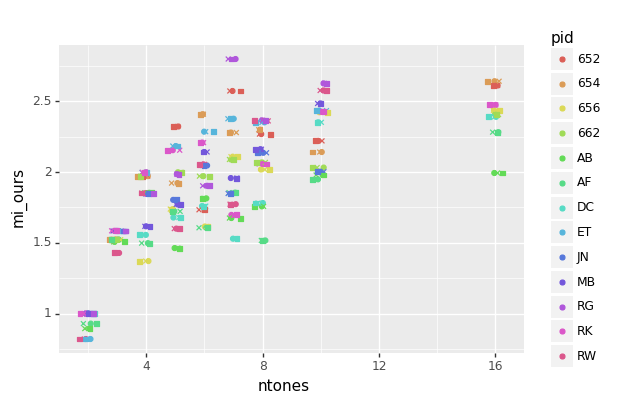

<ggplot: (8772291728325)>

In [ ]:
set_option('figure_size', None)
(ggplot(aes(x='ntones', color='pid'), data=different_MIs)
  +geom_jitter(aes(y='mi_ours'), shape='o', height=0, width=0.1)
  +geom_jitter(aes(y='mi_classif'), shape='x', height=0, width=0.2)
  +geom_jitter(aes(y='mi_score'), shape=',', height=0, width=0.3)
)

In [ ]:
different_MIs['ours_classif_diff'] = different_MIs['mi_ours'] - different_MIs['mi_classif']
different_MIs['classif_score_diff'] = different_MIs['mi_classif'] - different_MIs['mi_score']
different_MIs['ours_score_diff'] = different_MIs['mi_ours'] - different_MIs['mi_score']

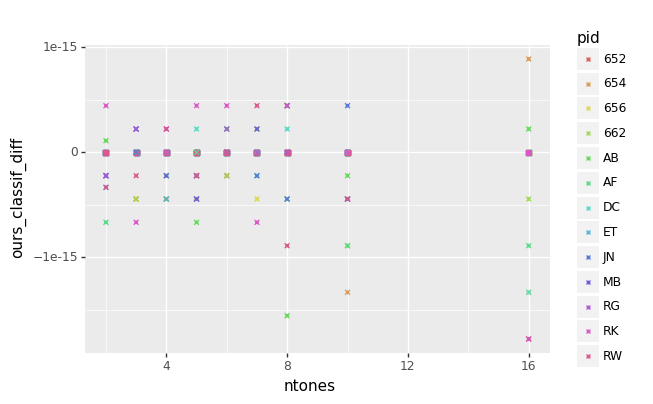

<ggplot: (8772292465593)>

In [ ]:
(ggplot(aes(x='ntones', color='pid'), different_MIs)
+geom_point(aes(y='ours_classif_diff'), shape='.')
+geom_point(aes(y='classif_score_diff'), shape=',')
+geom_point(aes(y='ours_score_diff'), shape='x')
)

### Comparing different MI functions
WARNING This doesn't include recent data, so the values for 16tones should not 
be treated as a good sample

In [ ]:
various_mi = df_from_drive('https://drive.google.com/file/d/1-1aeDHMye_RR3o6DNm2dYeMEnb-sOvow/view?usp=sharing')

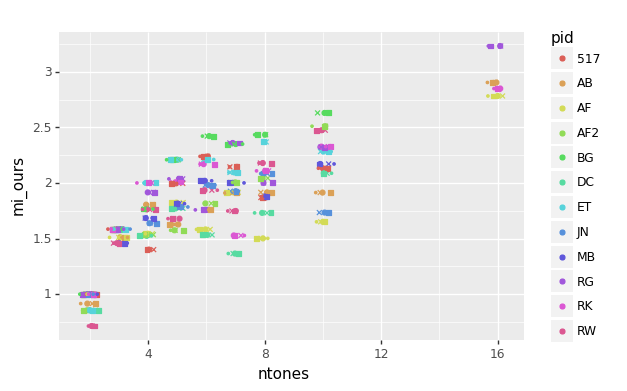

<ggplot: (8772292465453)>

In [ ]:
(ggplot(aes(x='ntones', color='pid'), data=various_mi)
  +geom_jitter(aes(y='mi_ours'), shape='o', height=0, width=0.1)
  +geom_jitter(aes(y='mi_classif'), shape='x', height=0, width=0.2)
  +geom_jitter(aes(y='mi_score'), shape=',', height=0, width=0.3)
  +geom_jitter(aes(y='infotheo_R_mi'), shape='.', height=0, width=0.4)
  #+geom_point(aes(y='mi_ours'), shape='o', alpha=0.5)
  #+geom_point(aes(y='mi_classif'), shape='x', alpha=0.5)
  #+geom_point(aes(y='mi_score'), shape=',', alpha=0.5)
  #+geom_point(aes(y='infotheo_R_mi'), shape='.', alpha=0.5)
)

## Plot mutual information

In [ ]:
def plot_mutual_info(dfs, title_text=None):
  def extract_mutual(df):
    # group by block condition (ie number of tones in block) and participant
    by_pid = df.groupby(['pid', 'ntones'])
  
    # source info per block = math.log(ntones, 2)
    pids_n_source_ = [(pid, math.log(ntones, 2)) for (pid, ntones), _ in by_pid]
    pids_, psource_ = zip(*pids_n_source_)
  
    # mutual info = mutual_info_score(correctResponse, response)
    pmutual_info_ = [calc_MI(data[(data['pid'] == pid) & (data['ntones'] == ntones)]['correctResponse'], 
                            data[(data['pid'] == pid) & (data['ntones'] == ntones)]['response'])
                    for (pid, ntones), data in by_pid]
    return pids_, psource_, pmutual_info_ 

  if type(dfs) == list:
    num_dfs = len(dfs)
    pids, psource, pmutual_info, source_df = [], [], [], []
    for i, df in enumerate(dfs):
      pids_, psource_, pmutual_info_ = extract_mutual(df)
      # Add to our list of data from all df's passed
      pids.extend(pids_)
      psource.extend(psource_)
      pmutual_info.extend(pmutual_info_)
      source_df.extend([str(df.name)]*len(pids_))
  else:
    num_dfs = 1
    pids, psource, pmutual_info = extract_mutual(dfs)
    source_df = [dfs.name]*len(pids)

  # Set the aspect ration to 1
  domain_y = min(pmutual_info), max(psource)
  domain_x = 1.0, max(psource)
  aspect = (domain_y[1] - domain_y[0]) / (domain_x[1] - domain_x[0])
  w = 500
  
  # Set a custom title, if provided
  if not title_text:
    title = ['Mutual information in absolute judgement of pitch',
             '2^x unique tones per block (ie per datum)']
  else:
    title = str(title_text)

  plot_data = pd.DataFrame({'pid': pids, 'source': psource, 'mutual': pmutual_info, 'source_df': source_df})

  pid_base = alt.Chart(plot_data).encode(
      x=alt.X('source', 
              title=['Information of Source (bits)', 'ie log2(number of tones)'],
              scale=alt.Scale(domain=domain_x))
  ).properties(
      width=w,
      height=int(w * aspect),
      title={
        "text": title,
        "subtitle": ['Identity in red'],
        "color": "black",
        "subtitleColor": "green",
        "subtitleFontSize":20,
        "subtitlePadding": 10
      }
  )
  
  by_pid_plt = pid_base.mark_point(
          size=150,
          opacity=1
      ).encode(
          y=alt.Y('mutual', 
                  title='Mutual Information (bits)', 
                  scale=alt.Scale(domain=domain_y),
                  axis=alt.Axis(titleColor='black')),
          color=alt.Color('pid', title='Participant'),
          shape=alt.Shape('source_df', title='Dataset'))
  
  # Average line for each df source
  fits = []
  fit_colors = {0: 'blue', 1: 'green', 2: 'pink', 3: 'orange', 4: 'purple', 5: 'grey'}
  for i, source_id in enumerate(pd.unique(plot_data.source_df)):
    print(source_id)
    source_base = alt.Chart(
        plot_data[plot_data.source_df == source_id]
    ).encode(
      x=alt.X('source', 
              title=['Information of Source (bits)', 'ie log2(number of tones)'],
              scale=alt.Scale(domain=domain_x))
    ).properties(
        width=w,
        height=w * aspect,
        title={
          "text": title,
          "subtitle": ['Identity in red'],
          "color": "black",
          "subtitleColor": "green",
          "subtitleFontSize":20,
          "subtitlePadding": 10
        }
    )
    average = source_base.mark_line(color=fit_colors[i % len(fit_colors)], opacity=0.5).encode(y=alt.Y('mean(mutual)', 
                                                    title="Mean", 
                                                    scale=alt.Scale(domain=domain_y)))
    band = source_base.mark_errorband(extent='ci', color=fit_colors[i % len(fit_colors)]).encode(y=alt.Y('mutual', title="", scale=alt.Scale(domain=domain_y)))
    fits.append(average + band)
  
  identity = pid_base.mark_line(color='red', 
                                strokeDash=[10,10]
                    ).encode(y=alt.Y('source', title="", 
                                    scale=alt.Scale(domain=domain_y)))
                  
  
  summary_chart = alt.layer(*fits, identity, by_pid_plt).configure_title(
      fontSize=20,
      anchor='start',
      font='Helvetica'
  )#.resolve_scale(y='independent')
  return summary_chart

In [ ]:
response_df['response'][:10]

0    3
1    2
2    2
3    3
4    1
5    1
6    3
7    4
8    2
9    1
Name: response, dtype: int64

In [ ]:
plot_mutual_info(response_df)

trained responses


alt.LayerChart(...)

## Pooled mutual information

In [ ]:
pooled_mi =  (response_df 
 .groupby('ntones', as_index=False) 
 #.apply(lambda df: print(f'ntones: {df.ntones}, m={len(df.index)}')))
 .apply(our_mi_from_df_group)
 .set_axis(['ntones', 'mi'], axis=1)
)
pooled_mi

averaged_mi = (response_df
  .groupby(['ntones', 'pid'], as_index=False)
  .apply(our_mi_from_df_group)
  .set_axis(['ntones', 'pid', 'mi'], axis=1)
  .groupby(['ntones'], as_index=False)
  .agg('mean')
)
averaged_mi

pooled_vs_averaged = (
    pd.merge(pooled_mi, averaged_mi, 
             on='ntones', suffixes=('_pooled', '_averaged'))
    .assign(log_ntones = lambda df: [round(np.log2(x), 1) for x in df.ntones])
)
pooled_vs_averaged

,ntones,mi_pooled,mi_averaged,log_ntones
0,2,0.921040,0.940332,1.0
1,3,1.533509,1.542133,1.6
2,4,1.679477,1.795830,2.0
3,5,1.649016,1.872457,2.3
4,6,1.702536,1.965090,2.6
5,7,1.665270,2.043033,2.8
6,8,1.565638,2.087780,3.0
7,10,1.685903,2.280365,3.3
8,16,1.616945,2.404602,4.0


In [ ]:
pooled_vs_averaged_long = (pooled_vs_averaged
    .drop('ntones', axis=1)
    .set_index('log_ntones')
    .stack()
    .reset_index()
    .set_axis(['log_ntones', 'mi_paradigm', 'mi'], axis=1)
    .assign(mi_paradigm=lambda df: [paradigm[3:] for paradigm in df['mi_paradigm']])
)
pooled_vs_averaged_long

,log_ntones,mi_paradigm,mi
0,1.0,pooled,0.921040
1,1.0,averaged,0.940332
2,1.6,pooled,1.533509
3,1.6,averaged,1.542133
4,2.0,pooled,1.679477
5,2.0,averaged,1.795830
6,2.3,pooled,1.649016
7,2.3,averaged,1.872457
8,2.6,pooled,1.702536
9,2.6,averaged,1.965090


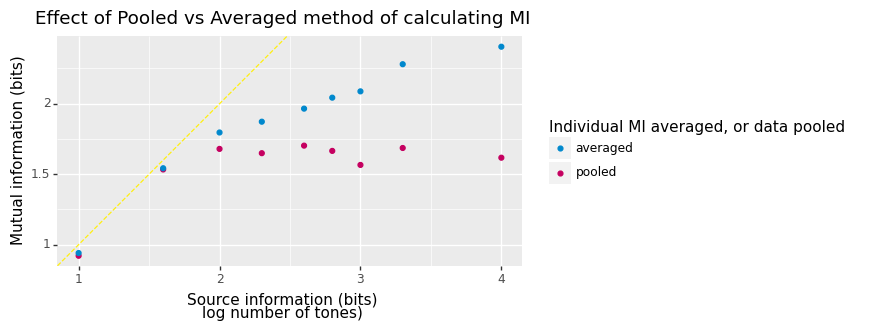

<ggplot: (8772292247525)>

In [ ]:
(
    ggplot(pooled_vs_averaged_long, aes(x='log_ntones', y='mi', 
                                        group='mi_paradigm', color='mi_paradigm'))
    + geom_abline(intercept=0, slope=1, color=niceyellow, linetype='dashed')
    + geom_point()
    + coord_fixed()
    + ggtitle('Effect of Pooled vs Averaged method of calculating MI')
    + scale_color_manual([niceblue, nicemagenta])
    + labs(x='Source information (bits)\nlog number of tones)',
           y='Mutual information (bits)',
           color='Individual MI averaged, or data pooled')
)

### Looking at N/m ratio

In [ ]:
sample_ratio = (response_df
 .groupby(['ntones'], as_index=False)
 .apply(lambda df: len(df.index))
 .set_axis(['ntones', 'N'],axis=1)
 .astype({'ntones': 'int64'})
 .assign(m=lambda df: df.ntones**2)
 .astype({'ntones': 'category'})
 .assign(sample_bin_ratio=lambda df: df.N/df.m)
)

In [ ]:
sample_ratio

,ntones,N,m,sample_bin_ratio
0,2,400,4,100.000000
1,3,471,9,52.333333
2,4,450,16,28.125000
3,5,475,25,19.000000
4,6,536,36,14.888889
5,7,551,49,11.244898
6,8,550,64,8.593750
7,10,590,100,5.900000
8,16,744,256,2.906250


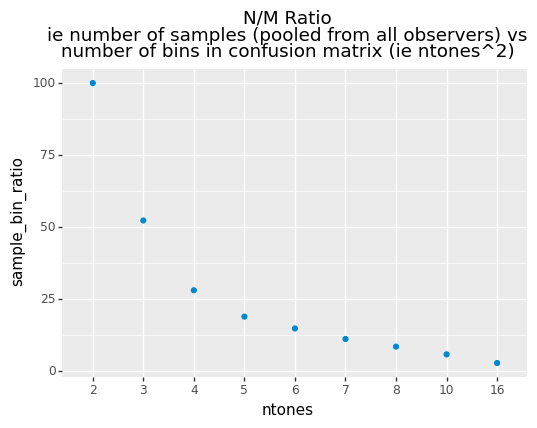

<ggplot: (8772292329197)>

In [ ]:
(
    ggplot(sample_ratio, aes(x='ntones'))
    + geom_point(aes(y='sample_bin_ratio'), color=niceblue)
    #+ geom_point(aes(y='N'), color=niceyellow)
    #+ geom_point(aes(y='m'), color=nicemagenta)
    + labs(title='N/M Ratio\nie number of samples (pooled from all observers) vs\nnumber of bins in confusion matrix (ie ntones^2)')
)

# Distribution of wrong answers


In [ ]:
wrong_df = response_df.copy()[response_df['correct'] == False] 
wrong_df.name = 'wrong_answers_only'

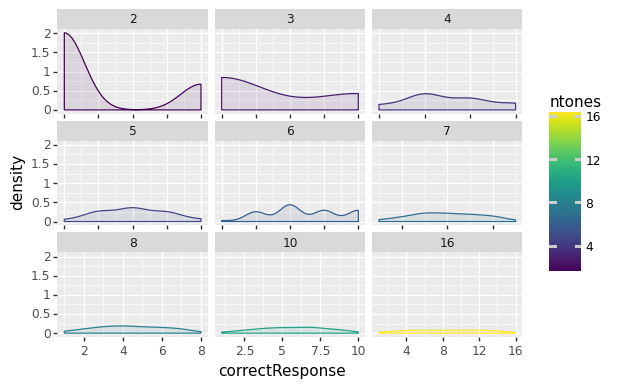

<ggplot: (8772292262965)>

In [ ]:
(ggplot(wrong_df, aes(x='correctResponse', color='ntones', fill='ntones'))
    + geom_density( alpha=0.1 )
    + facet_wrap('ntones', scales='free_x')
)

Edge effect

# Are wrong answers close?

In [ ]:
wrong_df['amount_wrong'] = abs(wrong_df['correctResponse'] - wrong_df['response'])

In [ ]:
wrong_df['ntones'].dtype

dtype('int64')

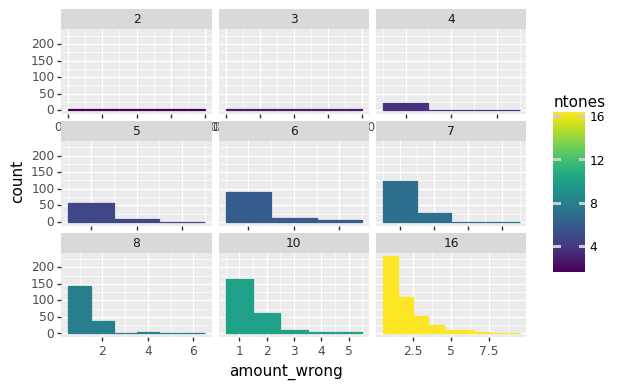

<ggplot: (8772291691757)>

In [ ]:
(ggplot(wrong_df, aes(x='amount_wrong', fill='ntones', color='ntones' ))
  + geom_histogram(binwidth=1)
    # + geom_density( alpha=0.1 )
  + facet_wrap('ntones', scales='free_x')
)

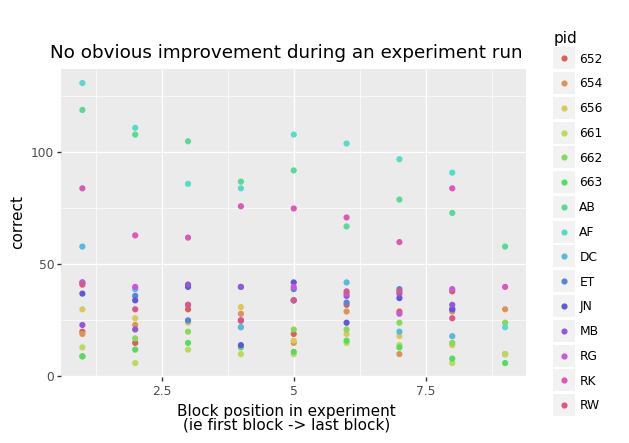

<ggplot: (8772302022153)>

In [ ]:
(ggplot(by_block, aes(x='block_sender_id'))
  #+ geom_bar(response_df[response_df['correct'] == True])
  + geom_point(aes(color='pid', y='correct'))
  + xlab("Block position in experiment\n(ie first block -> last block)")
  + ggtitle("No obvious improvement during an experiment run")
)

# Retest consistency?

In [ ]:
retest_df =   response_df[(response_df['pid'] =='AB') |
                          (response_df['pid'] =='517') |
                          (response_df['pid'] =='AF') |
                          (response_df['pid'] =='AF2')]
retest_df.name = 'retest'

In [ ]:
plot_mutual_info(retest_df)

retest


alt.LayerChart(...)

# Cleaning data (disregarding "training")

The participant is not expected to do well on the first trials of a block, since they must use feedback to learn the mapping of tones to labels. We should not include these early trials in our analysis.

In [ ]:
if include_training_data:
  plot_mutual_info([trained_df, response_df])

# Duration effect


In [ ]:
""" TODO Host these data publically
short_duration_files = [filename for filename in load_cvs("./drive/MyDrive/data") 
                          if ('_500' in filename)]
                          #(('AB' in filename) or
                          #('RG' in filename) or
                          #('AF' in filename) or
                          #('RK' in filename))]
long_duration_files = [filename for filename in load_cvs("./drive/MyDrive/data") 
if  ('_2500' in filename)]
#(('AB' in filename) or
#('RG' in filename) or
# ('AF' in filename) or
# ('RK' in filename))]
"""

' TODO Host these data publically\nshort_duration_files = [filename for filename in load_cvs("./drive/MyDrive/data") \n                          if (\'_500\' in filename)]\n                          #((\'AB\' in filename) or\n                          #(\'RG\' in filename) or\n                          #(\'AF\' in filename) or\n                          #(\'RK\' in filename))]\nlong_duration_files = [filename for filename in load_cvs("./drive/MyDrive/data") \nif  (\'_2500\' in filename)]\n#((\'AB\' in filename) or\n#(\'RG\' in filename) or\n# (\'AF\' in filename) or\n# (\'RK\' in filename))]\n'

In [ ]:
"""
short_duration_df = pd.concat([get_df_with_pid(filename, i) for i, filename in enumerate(short_duration_files)])
short_duration_df = short_duration_df[short_duration_df['sender'] == 'Get response']
short_duration_df.name = 'short_duration'

long_duration_df = pd.concat([get_df_with_pid(filename, i) for i, filename in enumerate(long_duration_files)])
long_duration_df = long_duration_df[long_duration_df['sender'] == 'Get response']
long_duration_df.name = 'long_duration'
"""

"\nshort_duration_df = pd.concat([get_df_with_pid(filename, i) for i, filename in enumerate(short_duration_files)])\nshort_duration_df = short_duration_df[short_duration_df['sender'] == 'Get response']\nshort_duration_df.name = 'short_duration'\n\nlong_duration_df = pd.concat([get_df_with_pid(filename, i) for i, filename in enumerate(long_duration_files)])\nlong_duration_df = long_duration_df[long_duration_df['sender'] == 'Get response']\nlong_duration_df.name = 'long_duration'\n"

In [ ]:
# plot_mutual_info([short_duration_df, long_duration_df], 'Short duration (500ms) vs Long duration (2500ms)')

# Number of trials effect


In [ ]:
"""
many_trials = [filename for filename in load_cvs("./drive/MyDrive/data") if '_short' not in filename]
few_trials = [filename for filename in load_cvs("./drive/MyDrive/data") if '_short' in filename]
"""

'\nmany_trials = [filename for filename in load_cvs("./drive/MyDrive/data") if \'_short\' not in filename]\nfew_trials = [filename for filename in load_cvs("./drive/MyDrive/data") if \'_short\' in filename]\n'

In [ ]:
"""
many_trials_df = pd.concat([get_df_with_pid(filename, i) for i, filename in enumerate(many_trials)])
many_trials_df = many_trials_df[many_trials_df['sender'] == 'Get response']
many_trials_df.name = 'many_trials'

few_trials_df = pd.concat([get_df_with_pid(filename, i) for i, filename in enumerate(few_trials)])
few_trials_df = few_trials_df[few_trials_df['sender'] == 'Get response']
few_trials_df.name = 'few_trials'
"""

"\nmany_trials_df = pd.concat([get_df_with_pid(filename, i) for i, filename in enumerate(many_trials)])\nmany_trials_df = many_trials_df[many_trials_df['sender'] == 'Get response']\nmany_trials_df.name = 'many_trials'\n\nfew_trials_df = pd.concat([get_df_with_pid(filename, i) for i, filename in enumerate(few_trials)])\nfew_trials_df = few_trials_df[few_trials_df['sender'] == 'Get response']\nfew_trials_df.name = 'few_trials'\n"

In [ ]:
# plot_mutual_info([few_trials_df, many_trials_df], 'Few vs Many Trials')

# Known simulation


## Identity Model


In [ ]:
from random import randint

In [ ]:
# Identity model
stimuli, response, trial_id, ntones, pid = [], [], [], [], []
for participant in range(10):
  for ntone in [2,3,4,5,6,7,8,10,16,32]:
    for trial in range(100):
      stimulus = trial%ntone + 1

      stimuli.append(stimulus)      
      response.append(stimulus)
      trial_id.append(trial)
      ntones.append(ntone)
      pid.append(str(participant))
identity_model_df = pd.DataFrame({
    'response': response,
    'correctResponse': stimuli,
    'pid': pid,
    'ntones': ntones, 
    'trial_id': trial_id
})
identity_model_df.name = 'modeled_perfect_observers'

In [ ]:
plot_mutual_info(identity_model_df)

modeled_perfect_observers


alt.LayerChart(...)

In [ ]:
def answer_wrong(row):
  correct = row['correctResponse']
  return random.choice([x for x in range(1, int(row['ntones'])+1) 
                              if x != correct])

In [ ]:
not_identity_model_df = identity_model_df.copy()
not_identity_model_df.name = 'modeled_perfectly_wrong_observers'
not_identity_model_df['response'] = not_identity_model_df.apply(answer_wrong, axis=1)

In [ ]:
plot_mutual_info([identity_model_df, not_identity_model_df])

modeled_perfect_observers
modeled_perfectly_wrong_observers


alt.LayerChart(...)

## Perfect responses

In [ ]:
perfect_observers_df = response_df.copy()
perfect_observers_df.name = 'perfect_observers'
perfect_observers_df['response'] = perfect_observers_df['correctResponse']

In [ ]:
plot_mutual_info(perfect_observers_df)

perfect_observers


alt.LayerChart(...)

## Perfectly bad observers
Observers get every answer wrong

In [ ]:
wrong_df = response_df.copy()
wrong_df.name = 'perfectly_wrong_observers'
wrong_df['response'] = wrong_df.apply( answer_wrong, axis=1 )

In [ ]:
plot_mutual_info([perfect_observers_df, not_identity_model_df, wrong_df])

perfect_observers
modeled_perfectly_wrong_observers
perfectly_wrong_observers


alt.LayerChart(...)

Given the observer always gets the answer wrong,
more observations (ie the modeled, rather than actual stimuli)
lower the mutual information.

## Chance responses
Given n tones in this block, answer each trial correctly with with (1/n)% chance.

In [ ]:
def answer_correct_by_chance(row):
  return random.randint(1, int(row.ntones))

In [ ]:
chance_observers_df = response_df.copy()
chance_observers_df.name = 'chance_observers'
chance_observers_df['response'] = chance_observers_df.apply(
    answer_correct_by_chance, axis=1
)

In [ ]:
plot_mutual_info([chance_observers_df, response_df])

chance_observers
trained responses


alt.LayerChart(...)

Given the same stimuli, chance performance is consistently lower than that of our participants.


## Correct for first n tones, then chance

In [ ]:
def chance_after_n(row, n):
  correct = row['correctResponse']
  if row['ntones'] <= n:
    give_correct_answer = True
  else:
    give_correct_answer = random.random() < 1/row['ntones']

  if give_correct_answer:
    response = correct
  else:
    response = random.choice([x for x in range(1, int(row['ntones'])+1) 
                              if x != correct])
  return response

In [ ]:
chance_after_five_df = response_df.copy()
chance_after_five_df.name = 'chance_after_5'
chance_after_five_df['response'] = chance_after_five_df.apply(
    lambda row: chance_after_n(row, 5), axis=1
)
chance_after_seven = response_df.copy()
chance_after_seven.name = 'chance_after_7'
chance_after_seven['response'] = chance_after_seven.apply(
    lambda row: chance_after_n(row, 7), axis=1
)

Turns out -- as you'd expect, if you actually thought about it (which I didn't) -- this just puts the first n points along the identity, then returns to the correct_answers_by_choice trend. Not very informative.

## n categories correct, then chance

Say we can always correctly place some n tones out of the possible ntones. 
These n tones are always answered correctly, though sometimes other tones are mistakenly considered one of the n (otherwise, there would be no options for incorrect answers, eg when ntones=6, n=5). 
For the other tones, the observer just answers by chance.

In [ ]:
def n_correct_otherwise_chance(row, n):
  correct = row['correctResponse']

  list(range(1,row.ntones+1))
  # If the tone is one of the first n in the test series, answer correctly
  if correct <= n:
    return int(correct)
  return random.choice(range(1,row['ntones']+1)) 

In [ ]:
five_known_then_chance = response_df.copy()
five_known_then_chance.name = 'five_known_then_chance'
five_known_then_chance['response'] = five_known_then_chance.apply(
    lambda row: n_correct_otherwise_chance(row, 5), axis=1
) 

In [ ]:
seven_known_then_chance = response_df.copy()
seven_known_then_chance.name = 'seven_known_then_chance'
seven_known_then_chance['response'] = seven_known_then_chance.apply(
    lambda row: n_correct_otherwise_chance(row, 7), axis=1
) 

In [ ]:
nine_known_then_chance = response_df.copy()
nine_known_then_chance.name = 'nine_known_then_chance'
nine_known_then_chance['response'] = nine_known_then_chance.apply(
    lambda row: n_correct_otherwise_chance(row, 9), axis=1
)

In [ ]:
plot_mutual_info([chance_observers_df, five_known_then_chance, response_df])

chance_observers
five_known_then_chance
trained responses


alt.LayerChart(...)

In [ ]:
plot_mutual_info([five_known_then_chance, seven_known_then_chance, nine_known_then_chance, response_df])

five_known_then_chance
seven_known_then_chance
nine_known_then_chance
trained responses


alt.LayerChart(...)

What I'm getting out of this is: no matter the internal categorization limit, we are not collecting enough data to expect the 32 tone condition to be informative.

Our responses fall between the 5 and 7 bit models, suggesting we are not at all deviating from the expectations of Miller.

## Mod categories


In [ ]:
def mod_correct(row, n):
  base = min(n, row['ntones'])
  return row['correctResponse']%base

## Modeling effect of number of trials

### Many (200) vs Few (20) trials per block

In [ ]:
# TODO optimize this, ie generate approriate length np arrays, instead of (triple nested!!! so slow!) for loops

# n Trials model
def model_N_trials_per_block(n, 
                             nparticipants=20, 
                             tones_series=[2,3,4,5,6,7,8,10,16,32]):
  stimuli, response, trial_id, ntones, pid = [], [], [], [], []
  for participant in range(nparticipants):
    for ntone in tones_series:
      for trial in range(n):
        stimulus = trial%ntone + 1
  
        stimuli.append(stimulus)      
        response.append(random.choice(list(range(1, ntone+1))))
        trial_id.append(trial)
        ntones.append(ntone)
        pid.append(str(participant))
  n_trials_df = pd.DataFrame({
      'response': response,
      'correctResponse': stimuli,
      'pid': pid,
      'ntones': ntones, 
      'trial_id': trial_id
  })
  n_trials_df.name = str(n)+'_trials_per_block_random_answers'
  return n_trials_df

In [ ]:
trials_per_block_dfs = [model_N_trials_per_block(40), model_N_trials_per_block(400)]
if large_run:
  trials_per_block_dfs.append(model_N_trials_per_block(4000))

In [ ]:
trials_per_block_title = "40 vs 400 vs 4,000 trials per block" if large_run else "40 vs 400 trials per block"
plot_mutual_info(trials_per_block_dfs, )

40_trials_per_block_random_answers
400_trials_per_block_random_answers


alt.LayerChart(...)

### Few (5) vs Many (20) trials per tone per block

In [ ]:
# TODO optimize this, ie generate approriate length np arrays, instead of (triple nested!!! so slow!) for loops

# n Trials per tone model
def model_N_trials_per_tone(n, 
                            nparticipants=20, 
                            tones_series=[2,3,4,5,6,7,8,10,16,32]):
  stimuli, response, trial_id, ntones, pid = [], [], [], [], []
  for participant in range(nparticipants):
    for ntone in tones_series:
      for trial in range(n*ntone):
        stimulus = trial%ntone + 1
  
        stimuli.append(stimulus)      
        response.append(random.choice(list(range(1, ntone+1))))
        trial_id.append(trial)
        ntones.append(ntone)
        pid.append(str(participant))
  n_trials_df = pd.DataFrame({
      'random_response': response,
      'correctResponse': stimuli,
      'pid': pid,
      'ntones': ntones, 
      'trial_id': trial_id
  })
  n_trials_df.name = str(n)+'_trials_per_tone_random_answers'
  return n_trials_df

In [ ]:
max_bits_trials_per_tone = 3 if not large_run else 12
trials_effect_df = []
for trials_per_tone in (2**x for x in range(max_bits_trials_per_tone)):
  this_df = model_N_trials_per_tone(trials_per_tone)
  this_df['response'] = this_df.apply(
    lambda row: answer_correct_by_chance(row), axis=1
  )
  this_df['num_trials_per_tone'] = trials_per_tone
  trials_effect_df.append(this_df)
trials_effect_df = pd.concat(trials_effect_df)

In [ ]:
trials_effect_individual_summary = (
 trials_effect_df
 .groupby(['ntones', 'pid', 'num_trials_per_tone'], as_index=False)
 .apply(our_mi_from_df_group)
 .set_axis(['ntones', 'pid', 'num_trials_per_tone', 'mi'], axis=1)
 .assign(log_ntones=lambda df: np.log2(df.ntones),
         log_samples=lambda df: np.log2(df.num_trials_per_tone))
 .astype({'log_ntones': 'category', 'log_samples': 'category'})
 )

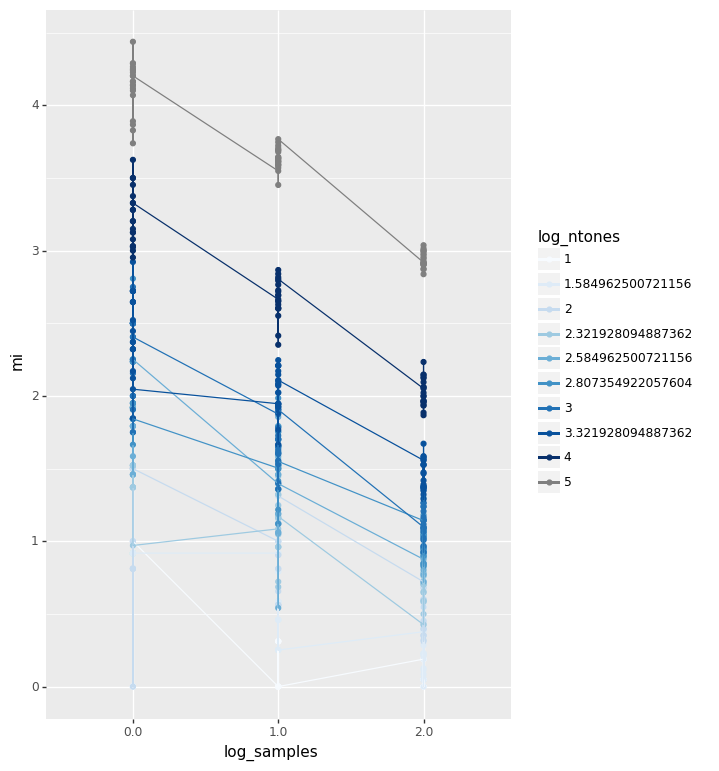

<ggplot: (8772291751765)>

In [ ]:
(
  ggplot(trials_effect_individual_summary, 
         aes(color='log_ntones', x='log_samples', y='mi', group='log_ntones'))
  # + geom_abline(aes(intercept=0, slope=1), color='red', linetype='dashed')
  + geom_point()
  + geom_line()
  + ggtitle('')
  + coord_fixed()
  + scale_color_brewer('seq'))


In [ ]:
trials_effect_individual_summary

,ntones,pid,num_trials_per_tone,mi,log_ntones,log_samples
0,2,0,1,0.000000,1.0,0.0
1,2,0,2,0.000000,1.0,1.0
2,2,0,4,0.188722,1.0,2.0
3,2,1,1,1.000000,1.0,0.0
4,2,1,2,0.311278,1.0,1.0
...,...,...,...,...,...,...
595,32,8,2,3.704784,5.0,1.0
596,32,8,4,2.874160,5.0,2.0
597,32,9,1,4.202820,5.0,0.0
598,32,9,2,3.767284,5.0,1.0


In [ ]:
def add_m(grp):
  print(list(grp))
  grp['m'] = grp['ntones']**2
  return grp

def add_N(grp):
  grp['N'] = len(grp.index)
  return grp

print(trials_effect_df)
trials_effect_population_summary = (trials_effect_df
   .astype({'ntones': 'int64', 'num_trials_per_tone': 'int64'})
   .groupby(['ntones', 'num_trials_per_tone'], as_index=False)
   .apply(lambda grp: grp.assign(m=lambda grp: grp.ntones**2))
   .reset_index(drop=True)
   .groupby(['ntones', 'num_trials_per_tone'], as_index=False)
   .apply(lambda grp: grp.assign(N=lambda grp: len(grp.index)))
   .reset_index(drop=True)
   .groupby(['ntones', 'num_trials_per_tone'], as_index=False)
   .apply(add_mi_to_group)
   .reset_index(drop=True)
   .groupby(['ntones', 'num_trials_per_tone'], as_index=False)
   .agg({'mi': 'mean', 'N': pd.unique, 'm': pd.unique})
)
trials_effect_population_summary

      random_response  correctResponse  ... response  num_trials_per_tone
0                   2                1  ...        2                    1
1                   1                2  ...        2                    1
2                   2                1  ...        3                    1
3                   3                2  ...        3                    1
4                   1                3  ...        2                    1
...               ...              ...  ...      ...                  ...
7435                3               28  ...       11                    4
7436                2               29  ...       31                    4
7437               16               30  ...        3                    4
7438                2               31  ...       28                    4
7439                7               32  ...        7                    4

[13020 rows x 7 columns]


,ntones,num_trials_per_tone,mi,N,m
0,2,1,0.007947,40,4
1,2,2,0.000458,80,4
2,2,4,0.016302,160,4
3,3,1,0.026115,60,9
4,3,2,0.023265,120,9
5,3,4,0.002854,240,9
6,4,1,0.061860,80,16
7,4,2,0.024104,160,16
8,4,4,0.021677,320,16
9,5,1,0.108835,100,25


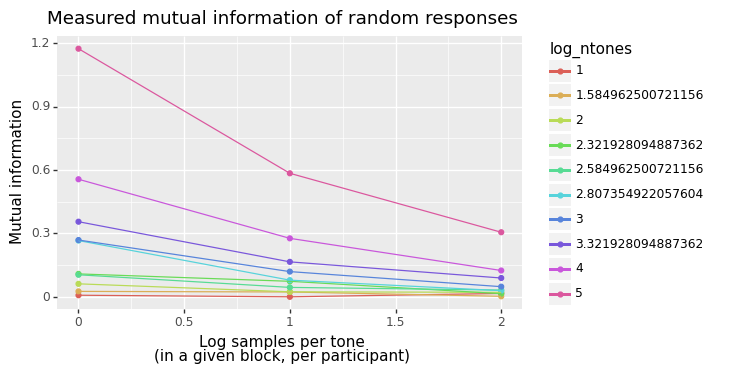

<ggplot: (8772291695065)>

In [ ]:
trials_effect_population_summary['log_ntones'] = np.log2(trials_effect_population_summary.ntones)
trials_effect_population_summary['log_samples'] = np.log2(trials_effect_population_summary['num_trials_per_tone'])
trials_effect_population_summary['nm_ratio'] = trials_effect_population_summary['N']/trials_effect_population_summary['m']
trials_effect_population_summary = trials_effect_population_summary.astype({'log_ntones': 'category'})

(
    ggplot(trials_effect_population_summary,
           aes(color='log_ntones', x='log_samples', y='mi', group='log_ntones'))
    +geom_point()
    +geom_line()
    +labs(x='Log samples per tone\n(in a given block, per participant)',
          y='Mutual information',
          title='Measured mutual information of random responses')
    +coord_fixed()
)

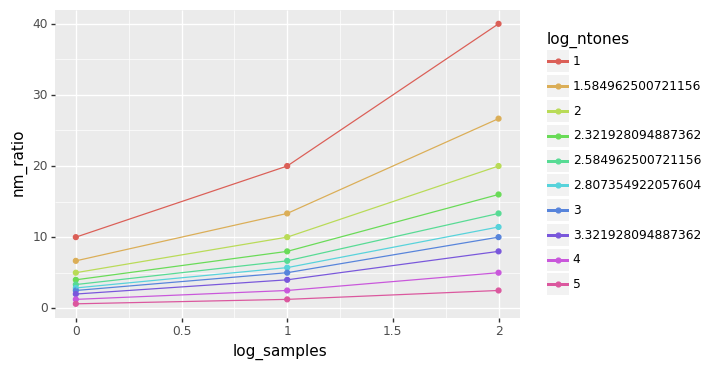

<ggplot: (8772289738797)>

In [ ]:
(
    ggplot(trials_effect_population_summary,
           aes(color='log_ntones', y='nm_ratio', x='log_samples', group='log_ntones'))
    +geom_point()
    +geom_line()
    )


# Demographics

In [ ]:
response_df

,pid,ntones,block_sender_id,level_3,Unnamed: 0,sender,sender_type,sender_id,timestamp,Unnamed: 5,confidence,consent,correct,correctResponse,debrief,desired_repetitions_per_tone,duration,ended_on,experience,headphone,pitch,response,response_action,time_commit,time_end,time_render,time_run,time_show,time_switch,tone_id,url,source_file_id,block_id,index,Unnamed: 32
0,652,3,2,5657,5657,Get response,html.Page,2311581.0,2021-03-10 00:46:15.273000+00:00,NaN,5,NaN,1,3,NaN,5.0,844.164,response,0,yes,no,3,click button#button3,400186.905,400184.595,399323.802,399324.740,399340.431,400189.449,3.0,NaN,j_2,1.0,348.0,NaN
1,652,3,2,5658,5658,Get response,html.Page,2311611.0,2021-03-10 00:46:19.609000+00:00,NaN,5,NaN,1,2,NaN,5.0,502.893,response,0,yes,no,2,click button#button2,404523.385,404521.045,404001.488,404002.950,404018.152,404533.343,2.0,NaN,j_2,1.0,356.0,NaN
2,652,3,2,5659,5659,Get response,html.Page,2311681.0,2021-03-10 00:46:23.875000+00:00,NaN,5,NaN,1,2,NaN,5.0,442.868,response,0,yes,no,2,click button#button2,408788.435,408786.045,408326.540,408327.955,408343.177,408792.465,2.0,NaN,j_2,1.0,368.0,NaN
3,652,3,2,5660,5660,Get response,html.Page,2311691.0,2021-03-10 00:46:28.191000+00:00,NaN,5,NaN,1,3,NaN,5.0,548.167,response,0,yes,no,3,click button#button3,413104.765,413102.165,412537.335,412538.145,412553.998,413119.599,3.0,NaN,j_2,1.0,374.0,NaN
4,652,3,2,5661,5661,Get response,html.Page,2311791.0,2021-03-10 00:46:32.427000+00:00,NaN,5,NaN,1,1,NaN,5.0,491.512,response,0,yes,no,1,click button#button1,417341.000,417338.770,416830.578,416832.990,416847.258,417346.223,1.0,NaN,j_2,1.0,389.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,RW,10,8,973,973,Get response,html.Page,1_3_7_2_35_1,2021-01-26T02:43:46.227Z,NaN,4,NaN,0,7,NaN,4.0,975.514,response,0,yes,no,5,click button#button5,2020663.455,2020662.790,2019673.945,2019749.580,2019687.276,2020594.260,7.0,NaN,2,NaN,NaN,NaN
4763,RW,10,8,974,974,Get response,html.Page,1_3_7_2_36_1,2021-01-26T02:43:50.538Z,NaN,4,NaN,1,5,NaN,4.0,538.896,response,0,yes,no,5,click button#button5,2024975.060,2024974.475,2024422.241,2024497.795,2024435.579,2024915.757,5.0,NaN,2,NaN,NaN,NaN
4764,RW,10,8,975,975,Get response,html.Page,1_3_7_2_37_1,2021-01-26T02:43:55.028Z,NaN,4,NaN,1,6,NaN,4.0,800.496,response,0,yes,no,6,click button#button6,2029464.785,2029464.210,2028650.381,2028726.045,2028663.714,2029397.318,6.0,NaN,2,NaN,NaN,NaN
4765,RW,10,8,976,976,Get response,html.Page,1_3_7_2_38_1,2021-01-26T02:43:59.302Z,NaN,4,NaN,1,4,NaN,4.0,605.975,response,0,yes,no,4,click button#button4,2033738.490,2033737.905,2033118.590,2033194.125,2033131.930,2033665.449,4.0,NaN,2,NaN,NaN,NaN


In [ ]:
mi_summary = (response_df
              .groupby(['pid', 'ntones', 'source_file_id'])
              .apply(our_mi_from_df_group)
              .reset_index()
              .rename(columns={0: 'mi'}))
confidence_summary = (response_df
      .groupby(['pid', 'ntones', 'source_file_id'])
      .apply(lambda dfgrp: dfgrp['confidence'].iloc[0])
      .reset_index()
      .rename(columns={0: 'confidence'}))['confidence']

experience_summary = (response_df
      .groupby(['pid', 'ntones', 'source_file_id'])
      .apply(lambda dfgrp: dfgrp['experience'].iloc[0])
      .reset_index()
      .rename(columns={0: 'experience'}))['experience']

headphone_summary = (response_df
      .groupby(['pid', 'ntones', 'source_file_id'])
      .apply(lambda dfgrp: dfgrp['headphone'].iloc[0])
      .reset_index()
      .rename(columns={0: 'headphone'}))['headphone']

pitch_summary = (response_df
      .groupby(['pid', 'ntones', 'source_file_id'])
      .apply(lambda dfgrp: dfgrp['pitch'].iloc[0])
      .reset_index()
      .rename(columns={0: 'pitch'}))['pitch']
mi_summary['confidence'] = confidence_summary
mi_summary['experience'] = experience_summary
mi_summary['headphone'] = headphone_summary
mi_summary['pitch'] = pitch_summary

mi_summary

,pid,ntones,source_file_id,mi,confidence,experience,headphone,pitch
0,652,3,j_2,1.521928,5,0,yes,no
1,652,4,j_2,1.970951,6,0,yes,no
2,652,5,j_2,2.321928,6,0,yes,no
3,652,6,j_2,1.733206,5,0,yes,no
4,652,7,j_2,2.572879,6,0,yes,no
...,...,...,...,...,...,...,...,...
146,RW,5,2,1.600212,3,0,some,no
147,RW,6,2,2.054536,3,0,some,no
148,RW,7,2,1.772891,3,0,some,no
149,RW,8,2,2.361406,3,0,some,no


## Is confidence predictive of performance?

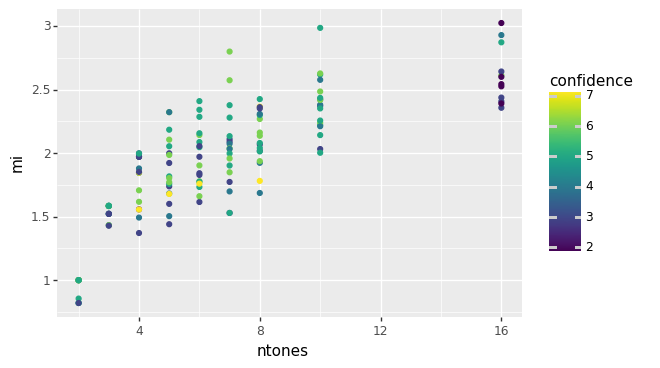

<ggplot: (8772289746941)>

In [ ]:
(ggplot(mi_summary, aes(x='ntones', y='mi', color='confidence'))
+geom_point())

In [ ]:
slope, intercept, r, p, stder  = spy.stats.linregress(mi_summary['confidence'], mi_summary['mi'])
r, p

(-0.09755115365559705, 0.23341351058967935)

## Is experience predictive of performance?

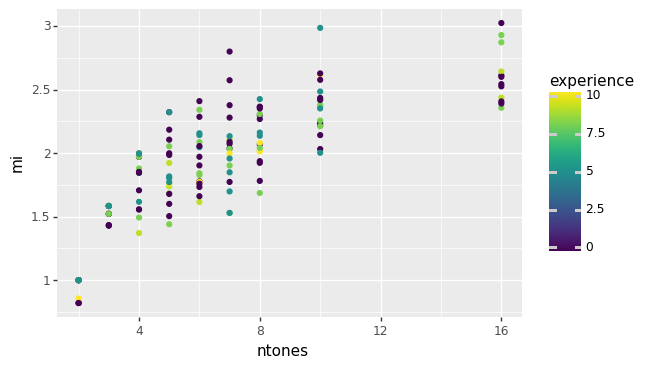

<ggplot: (8772289731509)>

In [ ]:
(ggplot(mi_summary, aes(x='ntones', y='mi', color='experience'))
+geom_point())

In [ ]:
#slope, intercept, r, p, stder  = spy.stats.linregress(mi_summary['experience'], mi_summary['mi'])
slope, intercept, r, p, stder  = spy.stats.linregress(mi_summary[mi_summary['ntones'] != 16]['experience'], mi_summary[mi_summary['ntones'] != 16]['mi'])
r, p

(-0.057411373560177816, 0.5020219034195863)

## Is headphone use predictive of performance?

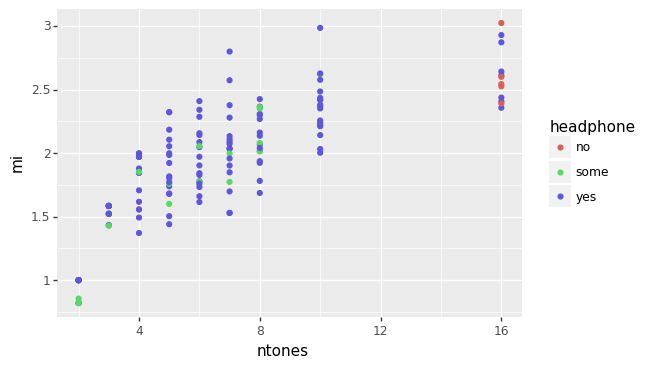

<ggplot: (8772289708517)>

In [ ]:
(ggplot(mi_summary, aes(x='ntones', y='mi', color='headphone'))
+geom_point())

## Is perfect pitch predictive?

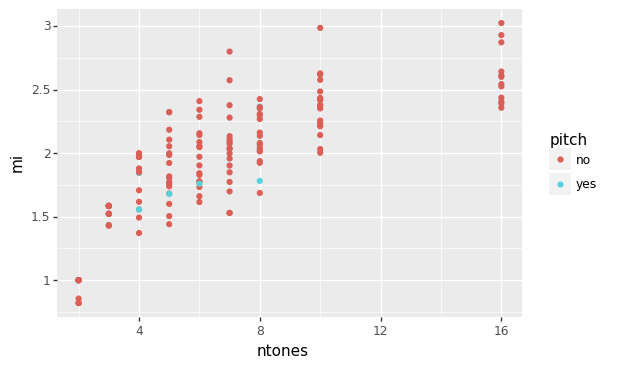

<ggplot: (8772289730401)>

In [ ]:
(ggplot(mi_summary, aes(x='ntones', y='mi', color='pitch'))
+geom_point())

# Sampling 

## With replacement (within samples)
Here we group by observer, stimuli condition (ie number of tones in this block), and the actual tone being played (such that we always sample the tones equally, so that we are not reducing the amount of source information), then sample N (ie samples_per_tone) times WITH replacement. We then repeat this M (ie num_samples) times.

The same observation may be found in any number of the M resamplings, AND any number of times within the N observations of a single such sample.

In [ ]:
# TODO have a smaller run for 'not large_run'
num_samples = 2 if not large_run else 10
sampled_w_replace_dfs = []
num_samples_range = (1,5)
for samples_per_tone in range(*num_samples_range):
  def sample_group(group):
    if len(group.index) < samples_per_tone:
      return None
    return group.sample(samples_per_tone, replace=True)

  sample = []
  for sample_id in range(num_samples):
    this_sample = (response_df                             #[(response_df.pid == 'AB') | (response_df.pid == 'AF')]
                  .groupby(['pid', 'ntones', 'correctResponse'], as_index=False)
                  .apply(sample_group))
    this_sample['sample_id'] = [sample_id]*len(this_sample.index)
    this_sample['sample_per_tone'] = [samples_per_tone]*len(this_sample.index)
    sample.append(this_sample)
  sample = pd.concat(sample)
  sample.name = f'sampled_{samples_per_tone}_time_per_tone_with_replacement'
  sampled_w_replace_dfs.append(sample)
sampled_w_replace_df = pd.concat(sampled_w_replace_dfs)
sampled_w_replace_df.name = 'large_sampled_w_repplacement_from_real_runs'

In [ ]:
sampled_w_replace_mi_summary = (sampled_w_replace_df
                      .groupby(['pid', 'ntones', 'sample_per_tone', 'sample_id'], as_index=False)
                      .apply(our_mi_from_df_group)
                      .rename({'pid':'pid', 
                               'ntones':'ntones', 
                               'sample_per_tone':'sample_per_tone', 
                               'sample_id':'sample_id',
                               None:'mi'}, axis=1)
                      .dropna())
sampled_w_replace_mi_summary

,pid,ntones,sample_per_tone,sample_id,mi
0,652,3,1,0,1.584963
1,652,3,1,1,1.584963
2,652,3,2,0,1.000000
3,652,3,2,1,1.000000
4,652,4,1,0,2.000000
...,...,...,...,...,...
815,RW,10,1,1,2.921928
816,RW,10,2,0,2.941446
817,RW,10,2,1,2.884184
818,RW,10,3,0,2.734940


In [ ]:
sampled_w_replace_mi_summary['log_ntones'] = [np.log2(x) for x in sampled_w_replace_mi_summary.ntones]

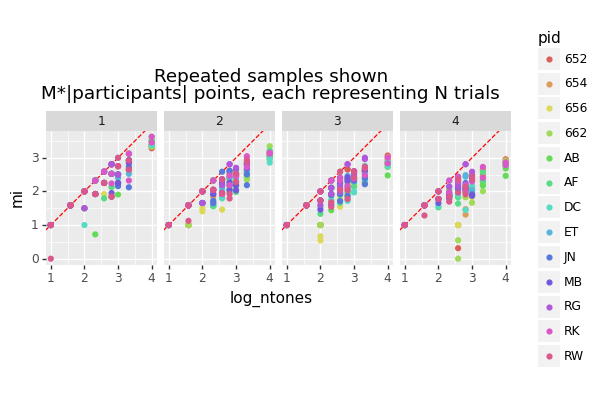

<ggplot: (8773917558705)>

In [ ]:
(
  ggplot(sampled_w_replace_mi_summary, aes(x='log_ntones', y='mi', color='pid'))
  + geom_abline(aes(intercept=0, slope=1), color='red', linetype='dashed')
  + coord_fixed()
  + geom_point()
  + facet_wrap('sample_per_tone', ncol=4)
  + ggtitle('Repeated samples shown\nM*|participants| points, each representing N trials')
)

In [ ]:
sampled_w_replace_mi_mean = (
    sampled_w_replace_mi_summary
    .drop(['sample_id', 'log_ntones'], axis=1)
    .groupby(['ntones', 'pid', 'sample_per_tone'], as_index=False)
    .agg(['mean', 'std'])
    .dropna()
    .reset_index()
    )
sampled_w_replace_mi_mean = pd.DataFrame(sampled_w_replace_mi_mean.to_records()).drop('index', axis=1)
sampled_w_replace_mi_mean.columns = ['ntones', 'pid', 'samples_per_tone', 'mean', 'std']
sampled_w_replace_mi_mean

,ntones,pid,samples_per_tone,mean,std
0,2,AB,1,1.000000,0.000000
1,2,AB,2,1.000000,0.000000
2,2,AB,3,1.000000,0.000000
3,2,AB,4,1.000000,0.000000
4,2,AF,1,1.000000,0.000000
...,...,...,...,...,...
405,16,DC,4,2.820563,0.052249
406,16,RK,1,3.538910,0.121750
407,16,RK,2,3.134013,0.018888
408,16,RK,3,2.922580,0.124692


In [ ]:
sampled_w_replace_mi_mean['log_ntones'] = [np.log2(x) for x in sampled_w_replace_mi_mean.ntones]

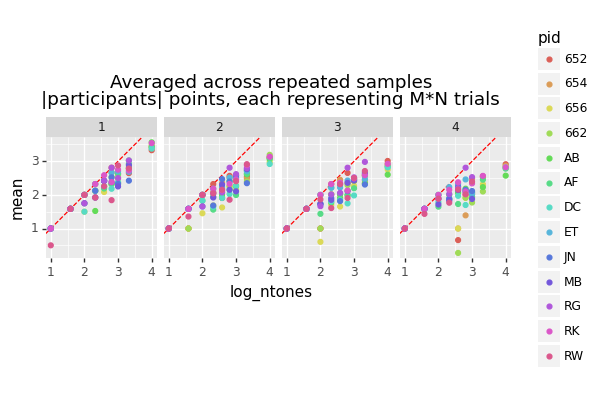

<ggplot: (8773907997429)>

In [ ]:
(ggplot(sampled_w_replace_mi_mean, aes(x='log_ntones', y='mean', color='pid'))
+ geom_abline(aes(intercept=0, slope=1), color='red', linetype='dashed')
+ coord_fixed()
+ geom_point()
+ggtitle('Averaged across repeated samples\n|participants| points, each representing M*N trials')
+facet_wrap('samples_per_tone', ncol=4))

In [ ]:
sampled_w_replace_mi_across_observers = (
    sampled_w_replace_mi_mean
    .drop(['pid', 'std', 'log_ntones'], axis=1)
    .groupby(['ntones', 'samples_per_tone'], as_index=False)
    #.agg([('mean', 'mean'), ('std', 'std')])
    .agg(['mean', 'std'])
    .dropna()
    .reset_index()
)
sampled_w_replace_mi_across_observers = pd.DataFrame(sampled_w_replace_mi_across_observers.to_records()).drop('index', axis=1)
sampled_w_replace_mi_across_observers.columns = ['ntones', 'samples_per_tone', 'mean', 'std']
sampled_w_replace_mi_across_observers

,ntones,samples_per_tone,mean,std
0,2,1,0.944444,0.166667
1,2,2,1.000000,0.000000
2,2,3,1.000000,0.000000
3,2,4,1.000000,0.000000
4,3,1,1.584963,0.000000
5,3,2,1.387315,0.275921
6,3,3,1.584963,0.000000
7,3,4,1.568251,0.050134
8,4,1,1.865385,0.194063
9,4,2,1.878441,0.183433


In [ ]:
sampled_w_replace_mi_across_observers['log_ntones'] = [np.log2(x) for x in sampled_w_replace_mi_across_observers.ntones]
sampled_w_replace_mi_across_observers['log_samples'] = [np.log2(x) for x in sampled_w_replace_mi_across_observers['samples_per_tone']]
sampled_w_replace_mi_across_observers['log_ntones'] = sampled_w_replace_mi_across_observers['log_ntones'].astype('category')
sampled_w_replace_mi_across_observers['log_samples'] = sampled_w_replace_mi_across_observers['log_samples'].astype('category')

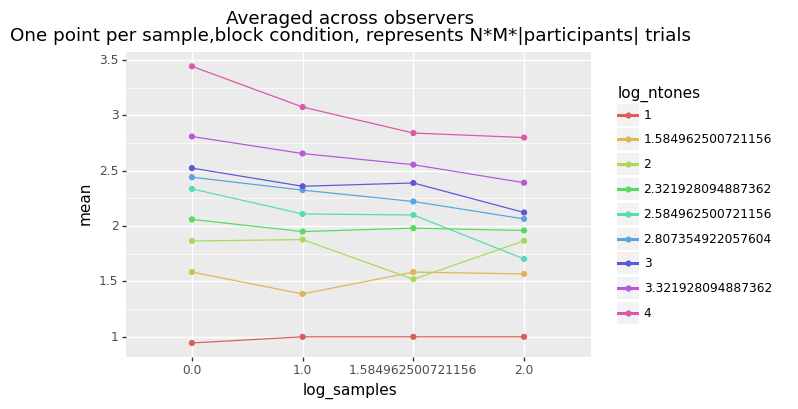

<ggplot: (8773908023505)>

In [ ]:
(
  ggplot(sampled_w_replace_mi_across_observers, aes(color='log_ntones', x='log_samples', y='mean', group='log_ntones'))
  # + geom_abline(aes(intercept=0, slope=1), color='red', linetype='dashed')
  + geom_point()
  + geom_line()
  + ggtitle('Averaged across observers\nOne point per sample,block condition, represents N*M*|participants| trials')
  + coord_fixed()
  # + scale_color_brewer('seq')
)

## Individual vs population differences

Miller, Nicely (1955) pool their data across observers, and look at just
population effects. This is done to increase the amount of data present,
ie the number of samples N, in order to minimize the bias in measuring
mutual information, as bias decreases as $N/m$ increases (where $m$ is
the cardinality of the source, ie the number of bins in the probability
distribution of X,Y; in our case, $m$ equals the square of the number
of tones in this block). Miller, Nicely have 4000 observations for each 16x16 confusion matrix.

If we can answer our questions using pooled data, than we effectively
reduce the amount of trials that each observer must run. If there are
lots of differences between the population and individual data, however,
we will have to collect a large $N$ per observer.

Here we explore mutual information obtained when sampling equally sized
datasets either from individual observers or from the pool of all 
observers' data.

In [ ]:
def get_indv_summary(sample):
  mi = (sample
        .groupby(['ntones', 'pid', 'sample_id'], as_index=False)
        .apply(our_mi_from_df_group)
        .set_axis(['ntones', 'pid', 'sample_id', 'mi'],axis='columns'))

  per_observer = (mi
                  .groupby(['ntones', 'pid'], as_index=False)
                  .agg({'mi': [np.mean, np.std]})
                  .set_axis(['ntones', 'pid', 'mean', 'std'], axis='columns')
                  .assign(log_ntones = lambda df: np.log2(df.ntones),
                          mi_min = lambda df: df['mean'] - (df['std']/2),
                          mi_max = lambda df: df['mean'] + (df['std']/2)))
  
  per_sample = (mi
                .groupby(['ntones', 'sample_id'], as_index=False)
                .agg({'mi': [np.mean, np.std]})
                .set_axis(['ntones', 'sample_id', 'mean', 'observer_std'], axis='columns')
                .assign(log_ntones = lambda df: np.log2(df.ntones),
                        mi_min = lambda df: df['mean'] - (df['observer_std']/2),
                        mi_max = lambda df: df['mean'] + (df['observer_std']/2)))

  summary =  (per_sample
              .drop(['observer_std', 'mi_max', 'mi_min'], axis=1)
              .groupby(['ntones'], as_index=False)
              .agg({'mean': [np.mean, np.std]})
              .set_axis(['ntones', 'mi', 'std'],axis='columns')
              .assign(mi_min=lambda df: df.mi - (df['std']/2),
                      mi_max=lambda df: df.mi + (df['std']/2),
                      log_ntones=lambda df: np.log2(df.ntones)))

  return per_observer, summary
  

In [ ]:
sample = []
num_samples = 20 if large_run else 2
m = 4000 
for sample_id in range(num_samples):
  def sampleM(grp):
    ntones = pd.unique(grp.ntones)[0]
    samples_per_tone = int(m/ntones)
    return grp.sample(samples_per_tone, replace=True)
  this_sample = (response_df
                .astype({'ntones': 'int64'})
                # .groupby(['pid', 'correctResponse', 'ntones'], as_index=False) # Individual
                .groupby(['correctResponse', 'ntones'], as_index=False)  # Population
                .apply(sampleM)
                )
  this_sample['sample_id'] = sample_id
  this_sample['sample_per_tone'] = m * (1/this_sample.ntones)
  this_sample['population_or_individual'] = 'population'
  sample.append(this_sample)
population_4000_sample = pd.concat(sample)
population_4000_sample.name = f'population_{m}m_{num_samples}s'

In [ ]:
population_4000_sample

pid  ntones  ...  sample_per_tone  population_or_individual
0  1775   AF       2  ...           2000.0                population
   3929   RK       2  ...           2000.0                population
   3421   MB       2  ...           2000.0                population
   1741   AF       2  ...           2000.0                population
   2942   ET       2  ...           2000.0                population
...      ...     ...  ...              ...                       ...
60 4450   RK      16  ...            250.0                population
   800   662      16  ...            250.0                population
   1612   AB      16  ...            250.0                population
   392   654      16  ...            250.0                population
   2572   AF      16  ...            250.0                population

[71984 rows x 38 columns]

In [ ]:
population_4000_samples = (population_4000_sample
                           .groupby(['ntones', 'sample_id'], as_index=False)
                           .apply(our_mi_from_df_group)
                           .set_axis(['ntones', 'sample_id', 'mi'], axis=1))
population_4000_samples

,ntones,sample_id,mi
0,2,0,0.927307
1,2,1,0.918021
2,3,0,1.553874
3,3,1,1.532152
4,4,0,1.691697
5,4,1,1.712178
6,5,0,1.636251
7,5,1,1.651642
8,6,0,1.732664
9,6,1,1.712210


In [ ]:
population_4000_summary = (population_4000_samples
                           .astype({'ntones': 'int64'})
                           .groupby(['ntones'], as_index=False)
                           .agg({'mi': [np.mean, np.std]})
                           .set_axis(['ntones', 'mi', 'std'], axis=1)
                           .assign(log_ntones=lambda df: np.log2(df.ntones),
                                   mi_min=lambda df: df.mi - (df['std']/2),
                                   mi_max=lambda df: df.mi + (df['std']/2))
)
population_4000_summary

,ntones,mi,std,log_ntones,mi_min,mi_max
0,2,0.922664,0.006566,1.000000,0.919381,0.925947
1,3,1.543013,0.015360,1.584963,1.535333,1.550693
2,4,1.701938,0.014482,2.000000,1.694697,1.709179
3,5,1.643947,0.010883,2.321928,1.638505,1.649388
4,6,1.722437,0.014463,2.584963,1.715206,1.729669
5,7,1.640224,0.018081,2.807355,1.631184,1.649265
6,8,1.564574,0.028882,3.000000,1.550133,1.579015
7,10,1.706400,0.036365,3.321928,1.688217,1.724582
8,16,1.640309,0.005343,4.000000,1.637637,1.642981


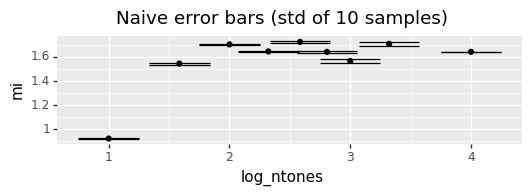

<ggplot: (8773908038605)>

In [ ]:
(ggplot(population_4000_summary, aes(x='log_ntones', y='mi'))
  + geom_point()
  + geom_errorbar(aes(ymin='mi_min', ymax='mi_max'))
  + coord_fixed()
  + labs(title='Naive error bars (std of 10 samples)')
)

In [ ]:
sample = []
num_samples = 20 if large_run else 2
m = 4000
for sample_id in range(num_samples):
  def sampleM(grp):
    ntones = pd.unique(grp.ntones)[0]
    samples_per_tone = int(m/ntones)
    return grp.sample(samples_per_tone, replace=True)
  this_sample = (response_df
                .astype({'ntones': 'int64'})
                .groupby(['pid', 'correctResponse', 'ntones'], as_index=False) # Individual
                # .groupby(['correctResponse', 'ntones'], as_index=False)  # Population
                .apply(sampleM)
                )
  this_sample['sample_id'] = [sample_id]*len(this_sample.index)
  this_sample['sample_per_tone'] = m * (1/this_sample.ntones)
  this_sample['population_or_individual'] = ['population']*len(this_sample.index)
  sample.append(this_sample)
individual_4000_sample = pd.concat(sample)
individual_4000_sample.name = f'individual_{m}m_{num_samples}s'

In [ ]:
individual_4000_mi = (individual_4000_sample
                           .groupby(['ntones', 'pid', 'sample_id'], as_index=False)
                           .apply(our_mi_from_df_group)
                           .set_axis(['ntones', 'pid', 'sample_id', 'mi'],axis='columns'))
individual_4000_mi

,ntones,pid,sample_id,mi
0,2,AB,0,0.903433
1,2,AB,1,0.892130
2,2,AF,0,0.924776
3,2,AF,1,0.936197
4,2,DC,0,1.000000
...,...,...,...,...
211,16,AF,1,2.279517
212,16,DC,0,2.449763
213,16,DC,1,2.427682
214,16,RK,0,2.479407


In [ ]:
individual_4000_per_observer = (individual_4000_mi
                                .groupby(['ntones', 'pid'], as_index=False)
                                .agg({'mi': [np.mean, np.std]})
                                .set_axis(['ntones', 'pid', 'mean', 'std'], axis='columns')
                                .assign(log_ntones = lambda df: np.log2(df.ntones),
                                        mi_min = lambda df: df['mean'] - (df['std']/2),
                                        mi_max = lambda df: df['mean'] + (df['std']/2))
                                )
individual_4000_per_observer

,ntones,pid,mean,std,log_ntones,mi_min,mi_max
0,2,AB,0.897782,0.007992,1.0,0.893786,0.901778
1,2,AF,0.930486,0.008076,1.0,0.926448,0.934525
2,2,DC,1.000000,0.000000,1.0,1.000000,1.000000
3,2,ET,0.821777,0.022724,1.0,0.810414,0.833139
4,2,JN,1.000000,0.000000,1.0,1.000000,1.000000
...,...,...,...,...,...,...,...
103,16,662,2.401411,0.001675,4.0,2.400574,2.402249
104,16,AB,1.994586,0.010757,4.0,1.989208,1.999965
105,16,AF,2.272024,0.010597,4.0,2.266725,2.277322
106,16,DC,2.438723,0.015614,4.0,2.430916,2.446530


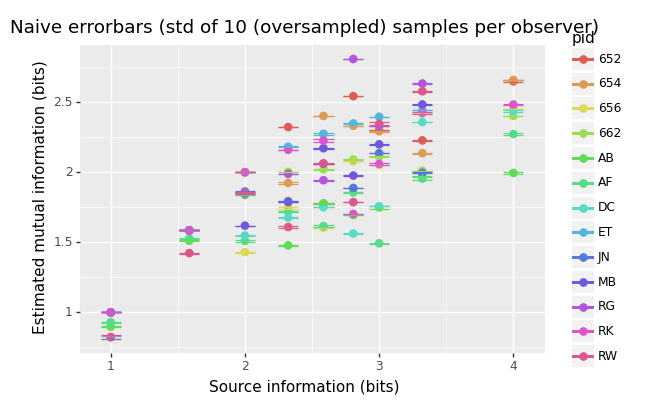

<ggplot: (8773917650869)>

In [ ]:
(ggplot(individual_4000_per_observer, aes(x='log_ntones', color='pid', y='mean'))
 + geom_point(size=2.5)
 + geom_errorbar(aes(ymin='mi_min', ymax='mi_max'), width=0.15)
 + labs(x='Source information (bits)', y='Estimated mutual information (bits)',
        title='Naive errorbars (std of 10 (oversampled) samples per observer)')
)

In [ ]:
individual_4000_summary = (individual_4000_per_observer
  .drop(['std', 'mi_max', 'mi_min'], axis=1)
  .groupby(['ntones'], as_index=False)
  .agg({'mean': [np.mean, np.std]})
  .set_axis(['ntones', 'mi', 'std'],axis='columns')
  .assign(mi_min=lambda df: df.mi - (df['std']/2),
          mi_max=lambda df: df.mi + (df['std']/2),
          log_ntones=lambda df: np.log2(df.ntones)
  )
)
individual_4000_summary

,ntones,mi,std,mi_min,mi_max,log_ntones
0,2,0.941719,0.076608,0.903415,0.980023,1.000000
1,3,1.562275,0.048665,1.537943,1.586608,1.584963
2,4,1.808567,0.209463,1.703835,1.913298,2.000000
3,5,1.875944,0.246590,1.752649,1.999239,2.321928
4,6,1.975608,0.256145,1.847536,2.103681,2.584963
5,7,2.051131,0.366241,1.868010,2.234251,2.807355
6,8,2.093347,0.273688,1.956503,2.230192,3.000000
7,10,2.280058,0.240858,2.159629,2.400487,3.321928
8,16,2.418240,0.212793,2.311844,2.524637,4.000000


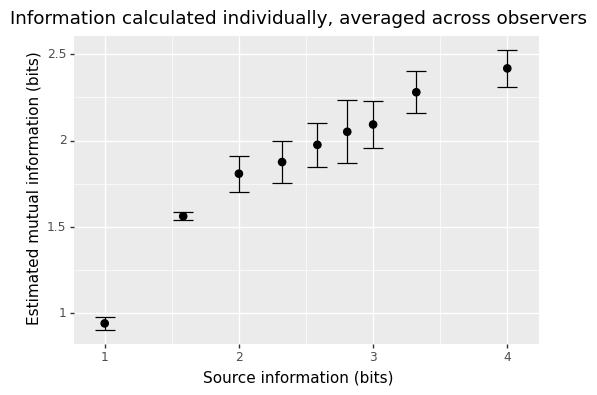

<ggplot: (8773917573369)>

In [ ]:
(ggplot(individual_4000_summary, aes(x='log_ntones', y='mi'))
 + geom_point(size=2.5)
 + geom_errorbar(aes(ymin='mi_min', ymax='mi_max'), width=0.15)
 + labs(x='Source information (bits)', y='Estimated mutual information (bits)',
        title='Information calculated individually, averaged across observers')
)

In [ ]:
compare_pop_individual_4000 = (
    pd.concat([population_4000_summary, individual_4000_summary], 
              axis=0, keys=['population', 'individual'], names=['schema'])
    .reset_index(level=[0])
)
compare_pop_individual_4000

,schema,ntones,mi,std,log_ntones,mi_min,mi_max
0,population,2,0.922664,0.006566,1.000000,0.919381,0.925947
1,population,3,1.543013,0.015360,1.584963,1.535333,1.550693
2,population,4,1.701938,0.014482,2.000000,1.694697,1.709179
3,population,5,1.643947,0.010883,2.321928,1.638505,1.649388
4,population,6,1.722437,0.014463,2.584963,1.715206,1.729669
5,population,7,1.640224,0.018081,2.807355,1.631184,1.649265
6,population,8,1.564574,0.028882,3.000000,1.550133,1.579015
7,population,10,1.706400,0.036365,3.321928,1.688217,1.724582
8,population,16,1.640309,0.005343,4.000000,1.637637,1.642981
0,individual,2,0.941719,0.076608,1.000000,0.903415,0.980023


Note that the errorbars in the next plot are potentially misleading.
Beyond the bias of mi which we are already aware, this plot is 
potentially deception in that the errorbars, while showing 
standard deviation for both groups, are based on unlike number
of points between groups.

That is, the individual schema's errorbars repesent the standard deviation
between the estimated (based on 20 samples of 4000 observations each) mi 
of each of the observers; the population schema's errorbars each represent
the std of 20 samples (of 4000 observations each). 
The number of observers != 20.

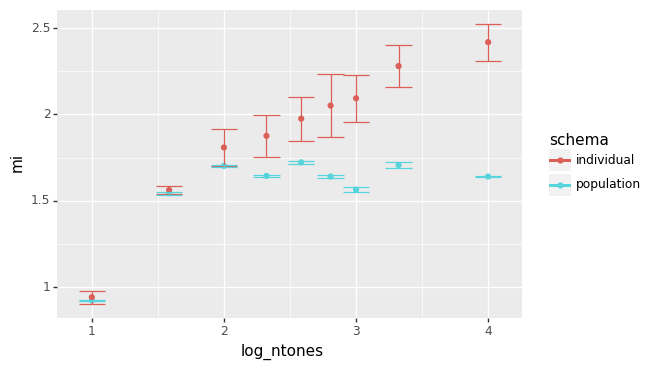

<ggplot: (8773917483829)>

In [ ]:
(ggplot(compare_pop_individual_4000,
        aes(x='log_ntones', color='schema', group='schema'))
  + geom_point(aes(y='mi'))
  + geom_errorbar(aes(ymin='mi_min', ymax='mi_max'), width=0.2)
)

## Pollack sized sample

Fig 2 of Pollack, 1952 suggests that mutual information was calculated with
just 30 observations, ie "Total judgements" is 30 for each
conditions 2,3,4,5,6,7,8,10.

From our review of the literature, we would expect these values to be
significantly positively biased, as, eg in the 10-tone condition, `N=30 >> m=100.`

In [ ]:
def get_pop_sample_summary(sample):
  samples = (sample
          .groupby(['ntones', 'sample_id'], as_index=False)
          .apply(our_mi_from_df_group)
          .set_axis(['ntones', 'sample_id', 'mi'], axis=1)
  )
  summary = (samples
            .astype({'ntones': 'int64'})
            .groupby(['ntones'], as_index=False)
            .agg({'mi': [np.mean, np.std]})
            .set_axis(['ntones', 'mi', 'std'], axis=1)
            .assign(log_ntones=lambda df: np.log2(df.ntones),
                    mi_min=lambda df: df.mi - (df['std']/2),
                    mi_max=lambda df: df.mi + (df['std']/2))
      
  )
  return summary

In [ ]:
def sample_m(m=20, s=20, schema='individual'):
  sample = []
  
  grouping_columns = {'individual': ['pid', 'correctResponse', 'ntones'],
                      'population': ['correctResponse', 'ntones']}[schema]
  for sample_id in range(s):
    def sampleM(grp):
      ntones = pd.unique(grp.ntones)[0]
      samples_per_tone = int(m/ntones)
      return grp.sample(samples_per_tone, replace=True)
    this_sample = (response_df
                  .astype({'ntones': 'int64'})
                  .groupby(grouping_columns, as_index=False)
                  .apply(sampleM)
                  )
    this_sample['sample_id'] = [sample_id]*len(this_sample.index)
    this_sample['sample_per_tone'] = m * (1/this_sample.ntones)
    this_sample['population_or_individual'] = schema
    sample.append(this_sample)
  sample = pd.concat(sample)

  name = f'{schema}_{m}m_{s}s'
  sample.name = name 

  return sample
  

In [ ]:
def sample_constant_nm(nm=1, s=20, schema='individual'):
  # N/m = 1
  sample = []
  grouping_columns = {'individual': ['pid', 'correctResponse', 'ntones'],
                      'population': ['correctResponse', 'ntones']}[schema]
  for sample_id in range(s):
    def sampleM(grp):
      ntones = pd.unique(grp.ntones)[0]
      samples_per_tone = ntones*nm # int(m/ntones)
      return grp.sample(samples_per_tone, replace=True)
    this_sample = (response_df
                  .astype({'ntones': 'int64'})
                  .groupby(grouping_columns, as_index=False)
                  .apply(sampleM)
                  )
    this_sample['sample_id'] = [sample_id]*len(this_sample.index)
    this_sample['sample_per_tone'] = this_sample.ntones*nm
    this_sample['population_or_individual'] = schema
    sample.append(this_sample)
  sample = pd.concat(sample)

  name = f'{schema}_{nm}nm_{s}s'
  sample.name = name 

  return sample

### Fig 2

In [ ]:
population_30_sample = sample_m(m=30, s=30, schema='population')

In [ ]:
population_30_sample

pid  ntones  ...  sample_per_tone  population_or_individual
0  2935   ET       2  ...           15.000                population
   2920   ET       2  ...           15.000                population
   4521   RW       2  ...           15.000                population
   911    AB       2  ...           15.000                population
   1796   AF       2  ...           15.000                population
...      ...     ...  ...              ...                       ...
56 2573   AF      16  ...            1.875                population
57 1699   AB      16  ...            1.875                population
58 2568   AF      16  ...            1.875                population
59 2498   AF      16  ...            1.875                population
60 148   652      16  ...            1.875                population

[7380 rows x 38 columns]

In [ ]:
population_30_samples = (population_30_sample
                           .groupby(['ntones', 'sample_id'], as_index=False)
                           .apply(our_mi_from_df_group)
                           .set_axis(['ntones', 'sample_id', 'mi'], axis=1))
population_30_samples

,ntones,sample_id,mi
0,2,0,1.000000
1,2,1,1.000000
2,2,2,1.000000
3,2,3,1.000000
4,2,4,0.820112
...,...,...,...
265,16,25,3.327820
266,16,26,3.625000
267,16,27,3.500000
268,16,28,3.030639


In [ ]:
population_30_summary = (population_30_samples
                           .astype({'ntones': 'int64'})
                           .groupby(['ntones'], as_index=False)
                           .agg({'mi': [np.mean, np.std]})
                           .set_axis(['ntones', 'mi', 'std'], axis=1)
                           .assign(log_ntones=lambda df: np.log2(df.ntones),
                                   mi_min=lambda df: df.mi - (df['std']/2),
                                   mi_max=lambda df: df.mi + (df['std']/2))
)
population_30_summary

,ntones,mi,std,log_ntones,mi_min,mi_max
0,2,0.948156,0.089744,1.000000,0.903283,0.993028
1,3,1.552733,0.065562,1.584963,1.519952,1.585513
2,4,1.785835,0.175120,2.000000,1.698275,1.873395
3,5,1.793463,0.189585,2.321928,1.698670,1.888255
4,6,1.967680,0.146994,2.584963,1.894183,2.041177
5,7,2.079664,0.216733,2.807355,1.971297,2.188030
6,8,2.183291,0.171567,3.000000,2.097507,2.269074
7,10,2.345132,0.141053,3.321928,2.274605,2.415658
8,16,3.330495,0.169402,4.000000,3.245794,3.415196


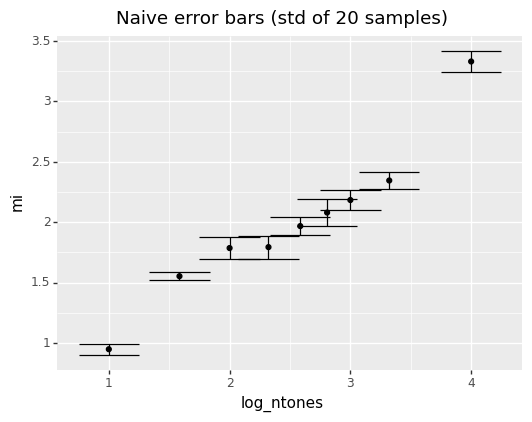

<ggplot: (8773905965885)>

In [ ]:
(ggplot(population_30_summary, aes(x='log_ntones', y='mi'))
  + geom_point()
  + geom_errorbar(aes(ymin='mi_min', ymax='mi_max'))
  + coord_fixed()
  + labs(title='Naive error bars (std of 20 samples)')
)

### Fig 3

In [ ]:
pop_120_sample = sample_m(m=120, schema='population', s=30)
pop_120_summary = get_pop_sample_summary(pop_120_sample)

indv_20_sample = sample_m(m=20, schema='individual', s=30)
indv_20_per_obs, indv_20_summary = get_indv_summary(indv_20_sample)

In [ ]:
fig_3_df = pd.concat([pop_120_summary, indv_20_summary], axis=0, 
                     names=['schema'], keys=['population_120', 'individual_20']).reset_index(level=[0])
fig_3_df 

,schema,ntones,mi,std,log_ntones,mi_min,mi_max
0,population_120,2,0.938500,0.052874,1.000000,0.912064,0.964937
1,population_120,3,1.559660,0.045321,1.584963,1.537000,1.582321
2,population_120,4,1.708784,0.061149,2.000000,1.678210,1.739359
3,population_120,5,1.715004,0.108949,2.321928,1.660530,1.769479
4,population_120,6,1.809011,0.121427,2.584963,1.748298,1.869725
5,population_120,7,1.734896,0.098752,2.807355,1.685520,1.784272
6,population_120,8,1.730190,0.104043,3.000000,1.678169,1.782212
7,population_120,10,1.884161,0.104293,3.321928,1.832015,1.936308
8,population_120,16,2.242821,0.109564,4.000000,2.188039,2.297602
0,individual_20,2,0.954669,0.033260,1.000000,0.938039,0.971299


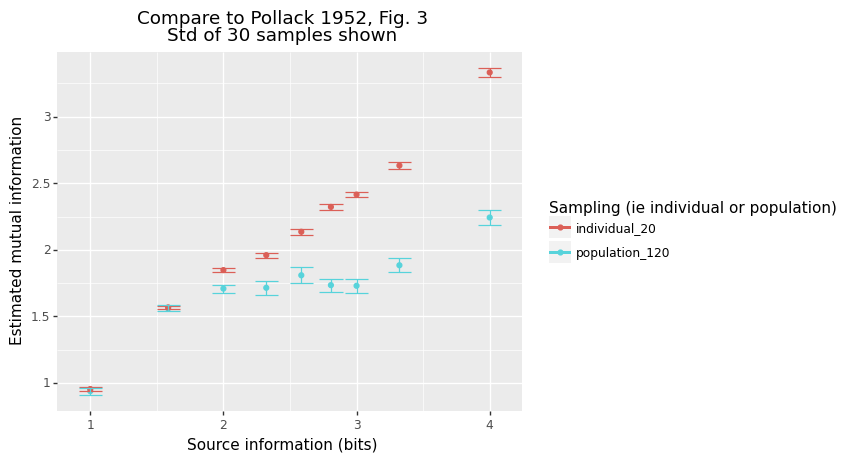

<ggplot: (8773905760521)>

In [ ]:
(ggplot(fig_3_df[fig_3_df.ntones <= 16], aes(x='log_ntones', color='schema', group='schema'))
+ geom_point(aes(y='mi'))
+ geom_errorbar(aes(ymin='mi_min', ymax='mi_max'), width=0.175)
+ coord_fixed()
+ labs(
    x='Source information (bits)',
    y='Estimated mutual information',
    color='Sampling (ie individual or population)',
    title='Compare to Pollack 1952, Fig. 3\nStd of 30 samples shown'
))

In [ ]:
num_samples = 50 if large_run else 5
pop_256_sample = sample_m(m=256, schema='population', s=num_samples)
pop_256_summary = get_pop_sample_summary(pop_256_sample)

# Note sampling individuals is very time consuming, as we're sampling a lot more data total 
indv_256_sample = sample_m(m=256, schema='individual', s=num_samples)
indv_256_per_obs, indv_256_summary = get_indv_summary(indv_256_sample)



In [ ]:
sample_256N_50s_df = pd.concat([pop_256_summary, indv_256_summary],
                               axis=0, names=['schema'], keys=['population_256', 'individual_256']).reset_index(level=[0])

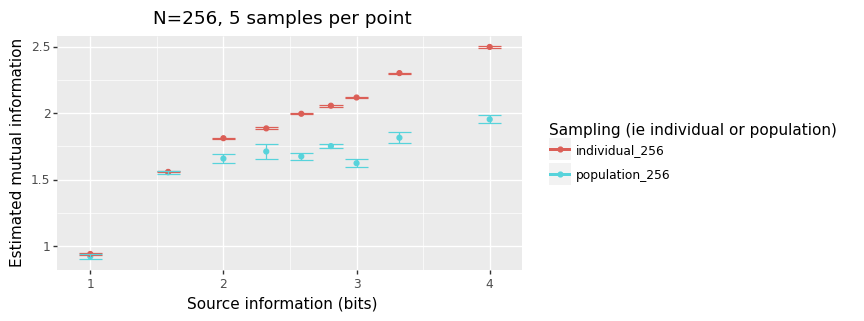

<ggplot: (8773917472485)>

In [ ]:
(ggplot(sample_256N_50s_df, aes(x='log_ntones', color='schema', group='schema'))
+ geom_point(aes(y='mi'))
+ geom_errorbar(aes(ymin='mi_min', ymax='mi_max'), width=0.175)
+ coord_fixed()
+ labs(
    x='Source information (bits)',
    y='Estimated mutual information',
    color='Sampling (ie individual or population)',
    title=f'N=256, {num_samples} samples per point'
))

In [ ]:
indv_256_per_obs

,ntones,pid,mean,std,log_ntones,mi_min,mi_max
0,2,AB,0.891849,0.021799,1.0,0.880950,0.902749
1,2,AF,0.961550,0.042698,1.0,0.940201,0.982899
2,2,DC,1.000000,0.000000,1.0,1.000000,1.000000
3,2,ET,0.809099,0.073213,1.0,0.772493,0.845705
4,2,JN,1.000000,0.000000,1.0,1.000000,1.000000
...,...,...,...,...,...,...,...
103,16,662,2.493807,0.029405,4.0,2.479104,2.508510
104,16,AB,2.118380,0.019482,4.0,2.108639,2.128121
105,16,AF,2.382830,0.052375,4.0,2.356643,2.409018
106,16,DC,2.484974,0.028044,4.0,2.470951,2.498996


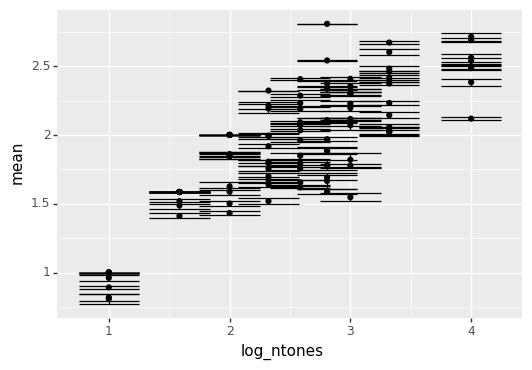

<ggplot: (8773905764573)>

In [ ]:
(ggplot(indv_256_per_obs, aes(x='log_ntones'))
+geom_point(aes(y='mean'))
+geom_errorbar(aes(ymin='mi_min', ymax='mi_max')))

In [ ]:
nsamples = 25 if large_run else 5
nm_2_individual =  sample_constant_nm(nm=2, s=25, schema='individual')
nm_2_population = sample_constant_nm(nm=2, s=25, schema='population')

indv_nm2_per_obs, indv_nm2_summary = get_indv_summary(nm_2_individual)
nm_2_population_summary = get_pop_sample_summary(nm_2_population)

sample_nm2_25s_df = pd.concat([indv_nm2_summary, nm_2_population_summary],
                               axis=0, names=['schema'], keys=['individual_nm2', 'population_nm2']).reset_index(level=[0])

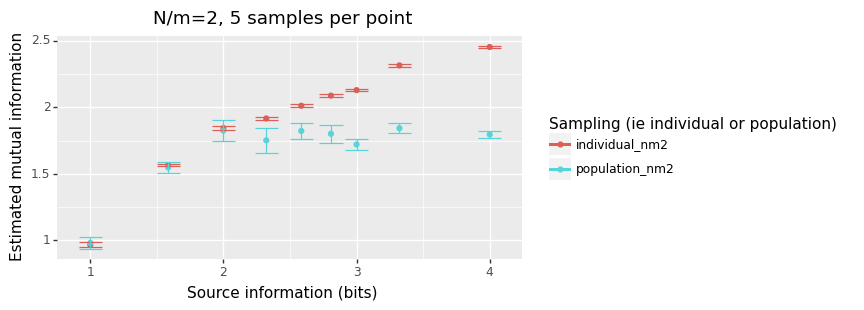

<ggplot: (8773908342281)>

In [ ]:
(ggplot(sample_nm2_25s_df, aes(x='log_ntones', color='schema', group='schema'))
+ geom_point(aes(y='mi'))
+ geom_errorbar(aes(ymin='mi_min', ymax='mi_max'), width=0.175)
+ coord_fixed()
+ labs(
    x='Source information (bits)',
    y='Estimated mutual information',
    color='Sampling (ie individual or population)',
    title=f'N/m=2, {nsamples} samples per point'
))

# Auto- and Cross- Correlations

In [ ]:
import statsmodels.api as sm
import statistics as stat
from collections import defaultdict

In [ ]:
def autocorrelate(df):
  r, q, p = sm.tsa.acf(df.response, nlags=3, qstat=True, missing='conservative')
  return pd.Series({'r1': r[1], 'p1': p[0],
                    'r2': r[2], 'p2': p[1],
                    'r3': r[3], 'p3': p[2]
                    })

In [ ]:
def crosscorrelate(df):
  # source: https://stackoverflow.com/questions/53436231/normalized-cross-correlation-in-python
  a = (df.response - np.mean(df.response)) / (np.std(df.response) * len(df.response))
  b = (df.correctResponse - np.mean(df.correctResponse)) / (np.std(df.correctResponse))

  # c= np.correlate(a,b, 'full')
  # return pd.Series({'r': c})
  c = np.correlate(a, b)
  return pd.Series({'r': c[0]})

  # return pd.Series({'r' : np.correlate(df['response'], df['correctResponse'])[0]}) # Not normalized

In [ ]:
def correlate(df):
  auto_dict = autocorrelate(df)
  cross_dict = crosscorrelate(df)
  return auto_dict.update(cross_dict)

## Autocorrelations

### Autocorrelation by Observer


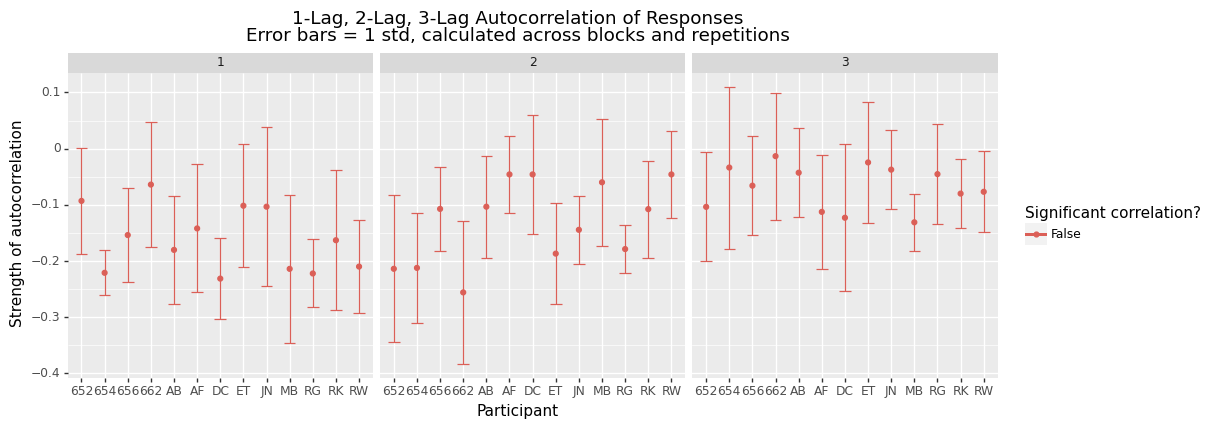

<ggplot: (8773917549189)>

In [ ]:
set_option('figure_size', (12,6))
set_option('aspect_ratio', 1)
autocorr_by_observer = (response_df
 .loc[:, ['ntones', 'pid', 'block_sender_id', 'response']]
 .groupby(['ntones', 'pid', 'block_sender_id'], as_index=False)
 .apply(autocorrelate)
 .groupby(['pid'], as_index=False)
 .agg(r_mean1=('r1',np.mean), 
      r_std1=('r1', np.std),
      p1=('p1', np.mean), 
      r_mean2=('r2',np.mean), 
      r_std2=('r2', np.std),
      p2=('p2', np.mean), 
      r_mean3=('r3',np.mean), 
      r_std3=('r3', np.std),
      p3=('p3', np.mean) 
 )
 .assign(
         ymin1=lambda df: df['r_mean1'] - df['r_std1']/2,
         ymax1=lambda df: df['r_mean1'] + df['r_std1']/2,
         significant1=lambda df: df['p1'] <= 0.05,
         ymin2=lambda df: df['r_mean2'] - df['r_std2']/2,
         ymax2=lambda df: df['r_mean2'] + df['r_std2']/2,
         significant2=lambda df: df['p2'] <= 0.05,
         ymin3=lambda df: df['r_mean3'] - df['r_std3']/2,
         ymax3=lambda df: df['r_mean3'] + df['r_std3']/2,
         significant3=lambda df: df['p3'] <= 0.05)
 .pipe(pd.wide_to_long, 
       stubnames=['p', 'r_mean', 'r_std', 'ymin', 'ymax', 'significant'],
       i='pid', j='lag')
 .reset_index()
)
(ggplot(autocorr_by_observer, aes(x='pid', color='significant', group='lag'))
+geom_point(aes(y='r_mean'))
+geom_errorbar(aes(ymin='ymin', ymax='ymax'))
+facet_grid('. ~ lag')
+labs(title='1-Lag, 2-Lag, 3-Lag Autocorrelation of Responses\nError bars = 1 std, calculated across blocks and repetitions',
      x='Participant',
      y='Strength of autocorrelation',
      column='Time lag (trial)',
      color='Significant correlation?')
)

### Autocorrelation by Block

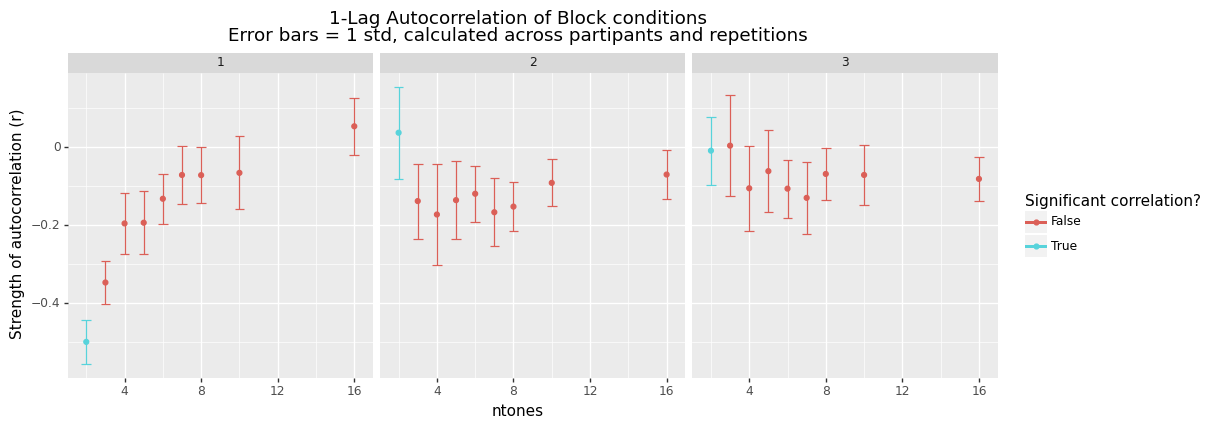

<ggplot: (8773917574929)>

In [ ]:
autocorr_by_block = (response_df
 .loc[:, ['ntones', 'pid', 'block_sender_id', 'response']]
 .groupby(['ntones', 'pid', 'block_sender_id'], as_index=False)
 .apply(autocorrelate)
 .groupby(['ntones'], as_index=False)
 .agg(r_mean1=('r1',np.mean), 
      r_std1=('r1', np.std),
      p1=('p1', np.mean), 
      r_mean2=('r2',np.mean), 
      r_std2=('r2', np.std),
      p2=('p2', np.mean), 
      r_mean3=('r3',np.mean), 
      r_std3=('r3', np.std),
      p3=('p3', np.mean) 
 )
 .assign(
         ymin1=lambda df: df['r_mean1'] - df['r_std1']/2,
         ymax1=lambda df: df['r_mean1'] + df['r_std1']/2,
         significant1=lambda df: df['p1'] <= 0.05,
         ymin2=lambda df: df['r_mean2'] - df['r_std2']/2,
         ymax2=lambda df: df['r_mean2'] + df['r_std2']/2,
         significant2=lambda df: df['p2'] <= 0.05,
         ymin3=lambda df: df['r_mean3'] - df['r_std3']/2,
         ymax3=lambda df: df['r_mean3'] + df['r_std3']/2,
         significant3=lambda df: df['p3'] <= 0.05)
 .pipe(pd.wide_to_long, 
       stubnames=['p', 'r_mean', 'r_std', 'ymin', 'ymax', 'significant'],
       i='ntones', j='lag')
 .reset_index()
)

(ggplot(autocorr_by_block, aes(x='ntones', color='significant'))
+geom_point(aes(y='r_mean'))
+geom_errorbar(aes(ymin='ymin', ymax='ymax'))
+facet_grid('. ~ lag')
+labs(title='1-Lag Autocorrelation of Block conditions\nError bars = 1 std, calculated across partipants and repetitions',
      y='Strength of autocorrelation (r)',
      color='Significant correlation?')
)

## Cross-correlation

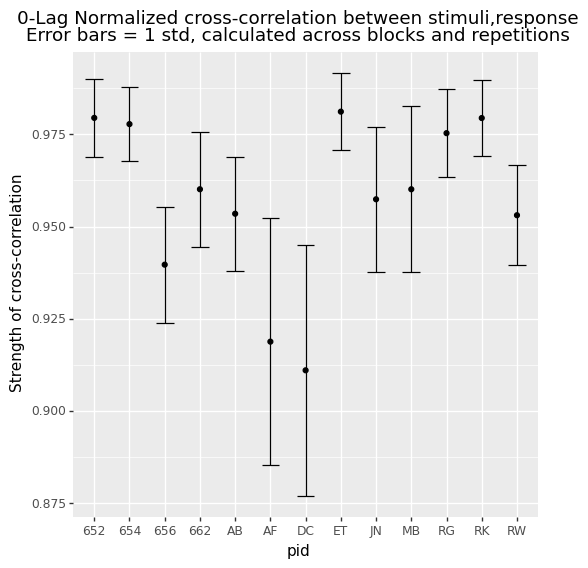

<ggplot: (8773905971673)>

In [ ]:
set_option('figure_size', None)
crosscorr_by_observer = (response_df
 .loc[:, ['ntones', 'pid', 'block_sender_id', 'response', 'correctResponse']]
 .groupby(['ntones', 'pid', 'block_sender_id'], as_index=False)
 .apply(crosscorrelate)
 .groupby(['pid'], as_index=False)
 .agg(r_mean=('r', np.mean),
      r_std =('r', np.std ))
 .assign(ymin=lambda df: df['r_mean'] - df['r_std']/2,
         ymax=lambda df: df['r_mean'] + df['r_std']/2)
)

(ggplot(crosscorr_by_observer, aes(x='pid'))
+geom_point(aes(y='r_mean'))
+geom_errorbar(aes(ymin='ymin', ymax='ymax'))
+labs(title='0-Lag Normalized cross-correlation between stimuli,response\nError bars = 1 std, calculated across blocks and repetitions',
      y='Strength of cross-correlation')
)

### Various lags cross-correlation
The above plot shows a single cross-correlation value per participant. 

An alternative approach would be to look at the cross-correlation strength as a function of lag for each observer, ie produce a histogram per observer, rather than a single datum.

The 'full' method of numpy.correlate does this, producing a value at each lag, ie at each time delay. We expect to see that the middle value of the series returned will be the largest, corresponding lag=0. If the same series is passed in as both 
variables of np.correlate, my understanding is that this center
value is the same as the autocorrelation (at lag=0? lag=1?) of that series.

In [ ]:
def crosscorr_series(df, var_a='response', var_b='correctResponse'):
  a = (df[var_a] - np.mean(df[var_a])) / (np.std(df[var_a]) * len(df[var_a]))
  b = (df[var_b] - np.mean(df[var_b])) / (np.std(df[var_b]))

  c= np.correlate(a,b, 'full')
  return c

We can now get this series of crosscorrelation values for each
block in the experiment, ie by grouping by block condition (`ntones`), observer (`pid`), and the particular run (`block_sender_id`).

In [ ]:
individual_blocks = (response_df
 .loc[:, ['ntones', 'pid', 'block_sender_id', 'response', 'correctResponse']]
 .groupby(['ntones', 'pid', 'block_sender_id'], as_index=False))

cross_correlations = defaultdict(list)
for grp in individual_blocks:
  ntones, pid, _ = grp[0]
  cross_correlations[(ntones, pid)].append(crosscorr_series(grp[1]))

For some participants (eg Ashley and me) we have multiple runs of the experiment, so there are multiple cross-correlation series for a given block condition. If we want a single summary series for each `pid`,`ntones` pair, we need to average across the multiple runs.

The function `pointwise_mean()` should do just that. In it, we expect a list of serieses. 
We multiply elements across each series, ie the first element from `serieses[0]`, the first element from `serieses[1]`, ..., the first element from `serieses[n]`, and so on for the length of each series (which should all be equal length),
then divide each element of this product series by `n`, ie 
`len(serieses)`.

As an example, if `serieses` consisted of 3 series, each of length `m`,
then we return a single series of length `m` where each value
of the series is the average of three different values.

In [ ]:
def pointwise_mean(serieses):
  def mode(l):
    # Implement our own mode function, because in this version of Python
    # (but not later versions, apparently, see: https://www.geeksforgeeks.org/python-statistics-mode-function/)
    # an error is returned if there isn't a unique mode
    try:
      return stat.mode(l)
    except:
      # In that case, just the largest value, as we would like to use the series(es)
      # with the most data.
      return max(l)

  try:
    # Check all elements are of the same length
    assert len(pd.unique([len(s) for s in serieses])) == 1
    # If so, do a pointwise mean as originally invisioned
    return np.prod(np.array(serieses), axis=0)/len(serieses)
  except:
    # If not all elements are of the same length, the `assert` above will raise
    # an error, and we will be sent here
    
    # To get by this, just take the largest possible subset of serieses that have consistent length
    same_len_serieses = [s for s in serieses if len(s) == mode([len(x) for x in serieses])]
    # Then return the pointwise mean of this subset of serieses
    return np.prod(np.array(same_len_serieses), axis=0)/len(same_len_serieses)


Uh oh, I'm a fool! Unfortunately, not every run of a given block-condition, ie `ntones` is the same length.
This is another complication of the previously noted unfortunate fact that we have not used consistent trial numbers.

As such, I've modified (muddied! uglified!) `pointwise_mean`. 
Now we first check that each series has the same number of elements (ie trials).
If that's not the case, we take each series with the mode number of trials, eg
if we had two serieses with 50 trials, and one series with 30 trials, we'll just
take the two serieses with 50 trials and take the `pointwise_mean()` of those two.

In [ ]:
avg_cross_correlations = {k: pointwise_mean(v) for k,v in cross_correlations.items()}

Now we need to actually plot these. We'll start by putting all these serieses
together into one long dataframe. 

We'll plot each observer and block condition pair separately. The 'x'
column I insert below is just an index which increase from 0 for each datum
within one `pid`,`ntones` pair, such that we can use it for our x axis when
plotting. 

The middle `x` value should be the cross-correlation given the lowest lag.

In [ ]:
def df_from_avg_cross_corr(keypair, cross_corrs):
  ntones, pid = keypair
  df = pd.DataFrame({'corr': cross_corrs})
  df['pid'] = pid
  df['ntones'] = ntones
  df['x'] = df.index
  return df

long_cross_corrs = pd.concat(df_from_avg_cross_corr(k,v) for k,v in avg_cross_correlations.items()).reset_index()
long_cross_corrs

,index,corr,pid,ntones,x
0,0,-5.196746e-04,AB,2,0
1,1,-2.227177e-03,AB,2,1
2,2,5.939139e-04,AB,2,2
3,3,-4.625929e-19,AB,2,3
4,4,-5.196746e-04,AB,2,4
...,...,...,...,...,...
7365,134,4.209050e-02,RK,16,134
7366,135,9.764572e-03,RK,16,135
7367,136,-1.389241e-02,RK,16,136
7368,137,-1.167712e-02,RK,16,137


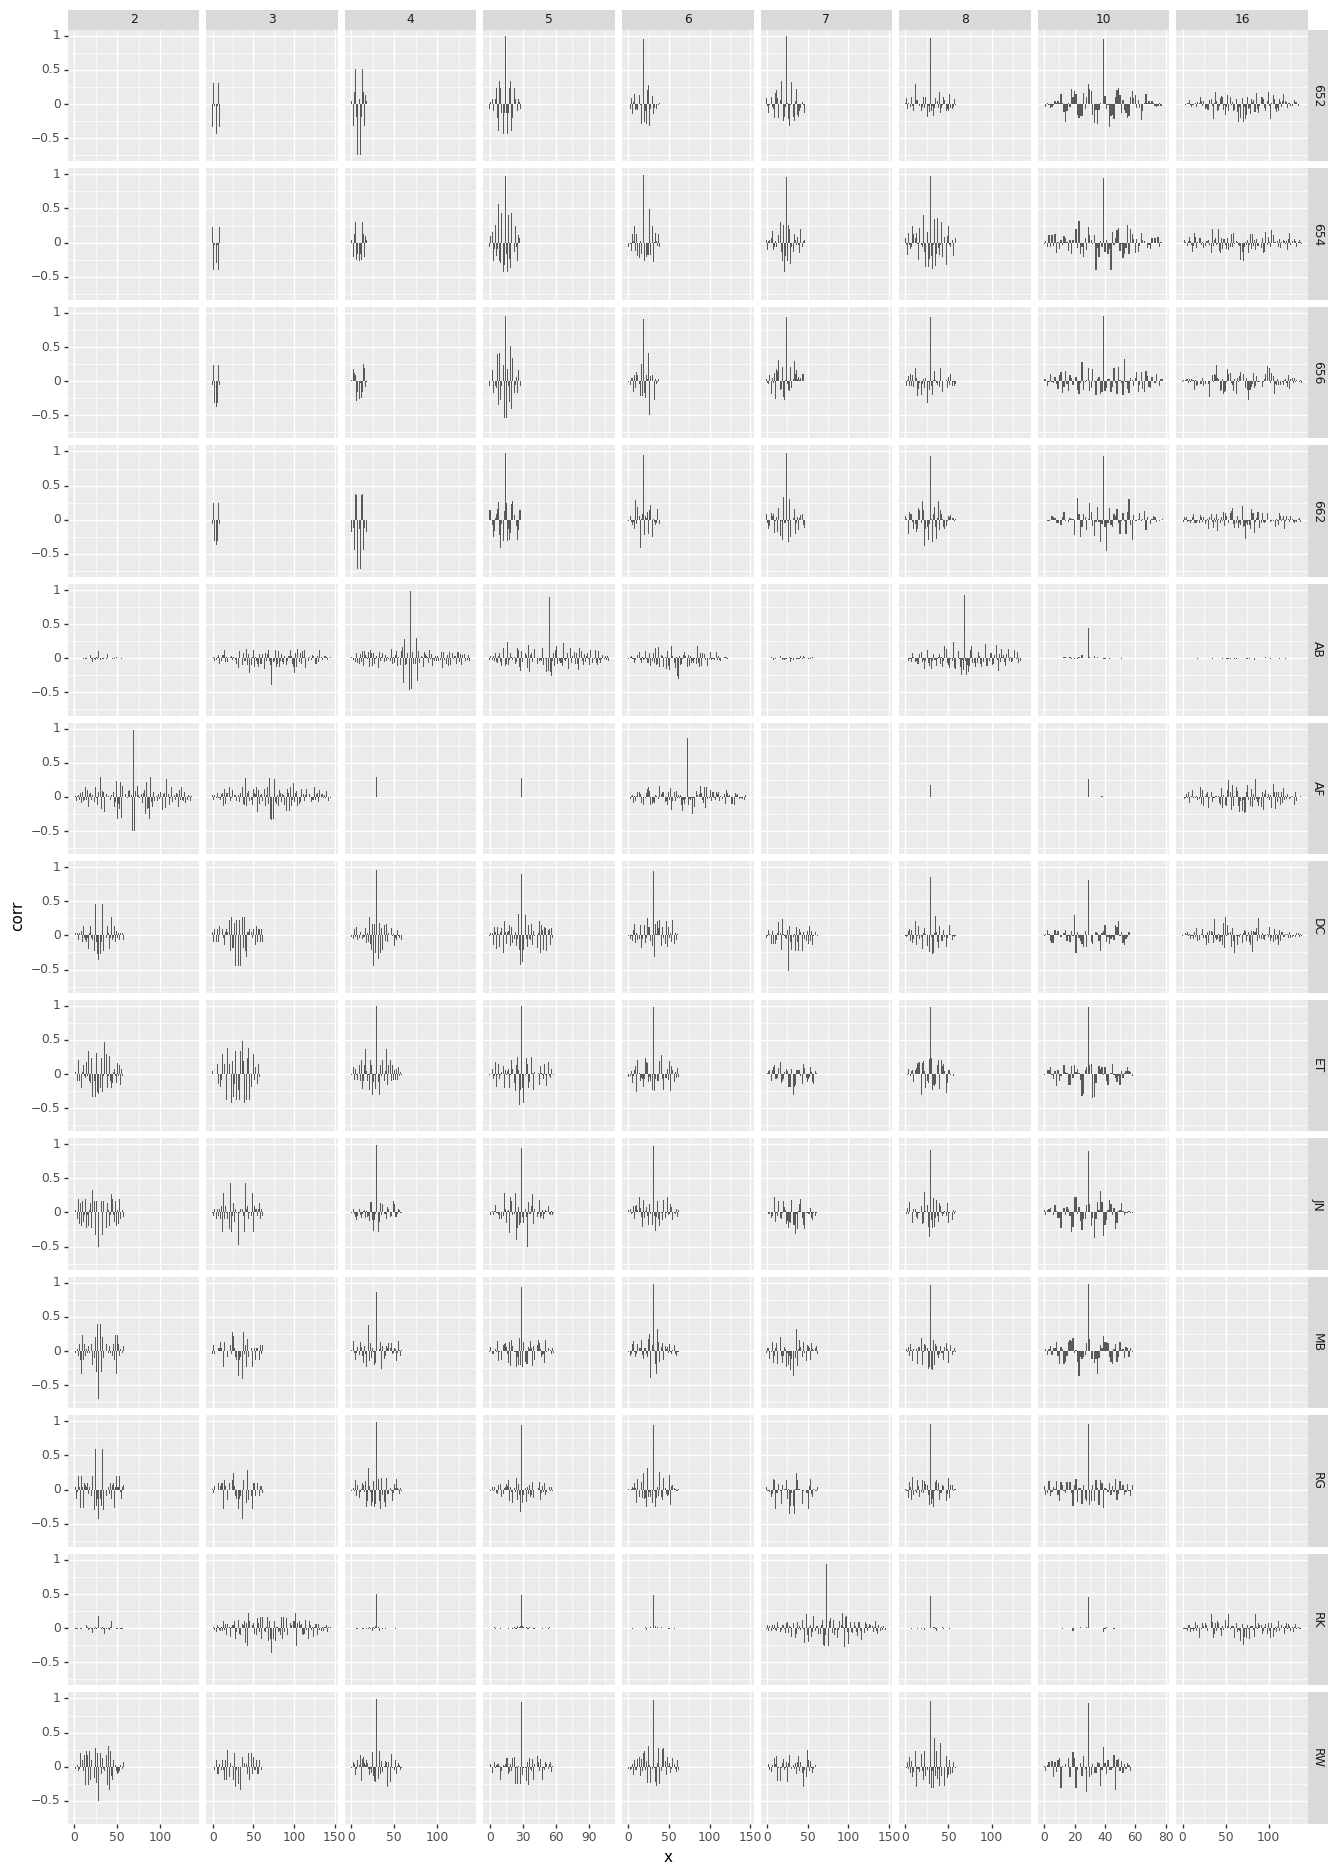

<ggplot: (8773908224069)>

In [ ]:
set_option('figure_size', (16,16))
(
    ggplot(long_cross_corrs, aes(x='x', y='corr'))
    + geom_bar(stat='identity')
    + facet_grid('pid ~ ntones', scales='free_x')
)

# Perfect, history-biased observer

I've been using the assign() function to add new columns to a given dataframe. We would now like to consider models of observers which consider previous trials; these cannot be accessed when considering one row of the dataframe (ie the paradigm of assign(). To (naively) get around this, we can add new columns, which represent the response or stimuli of a previous trial some steps back.

In [ ]:
# Wrapped scooting
l = list(range(10))
print(l)
print(l[-2:] + l[:-2])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[8, 9, 0, 1, 2, 3, 4, 5, 6, 7]


We'll call this behaviour 'scooting', because we're scooting the list down some number of steps.

NOTE: This method effectively wraps the values, ie for the first `n` values of our new historical columns, we are bringing values up from the end of the list.

Another sensible approach would be to assert that for the first `n` values
of the list there are no `n`-back trials, and mark this with NaN (not a number)
values.

In [ ]:
# Strict (ie non-wrappingscooting
n = 3
l = list(range(10))
print(l)
print([np.nan]*n + l[:-n])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[nan, nan, nan, 0, 1, 2, 3, 4, 5, 6]


In [ ]:
def scoot(l, n=3, wrap=False):
  if wrap:
    return l[-n:] + l[:-n]
  return [np.nan]*n + l[:-n]

NOTE: I've set the default value of `wrap` to `False`, as this seems like the 
more conservative approach. Thinking about/testing the effects of setting this
to `True` would be an interesting topic for further examination.

In [ ]:
def add_history(grp, n=3):
  previous_responses = [scoot(list(grp.response), x) for x in range(1, n+1)]
  previous_stimuli = [scoot(list(grp.correctResponse), x) for x in range(1, n+1)]
  for x in range(n):
    grp[f'response_{x+1}_back'] = previous_responses[x]
    grp[f'stimuli_{x+1}_back'] = previous_stimuli[x]
  return grp
#  return pd.Series({: old_responses for x, old_responses in enumerate(previous_responses)})

In [ ]:
historical_df = (response_df
                 .copy()
                 .groupby(['pid', 'ntones', 'block_sender_id'], as_index=False)
                 .apply(add_history, n=3)
)
historical_df

,pid,ntones,block_sender_id,level_3,Unnamed: 0,sender,sender_type,sender_id,timestamp,Unnamed: 5,confidence,consent,correct,correctResponse,debrief,desired_repetitions_per_tone,duration,ended_on,experience,headphone,pitch,response,response_action,time_commit,time_end,time_render,time_run,time_show,time_switch,tone_id,url,source_file_id,block_id,index,Unnamed: 32,response_1_back,stimuli_1_back,response_2_back,stimuli_2_back,response_3_back,stimuli_3_back
0,652,3,2,5657,5657,Get response,html.Page,2311581.0,2021-03-10 00:46:15.273000+00:00,NaN,5,NaN,1,3,NaN,5.0,844.164,response,0,yes,no,3,click button#button3,400186.905,400184.595,399323.802,399324.740,399340.431,400189.449,3.0,NaN,j_2,1.0,348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,652,3,2,5658,5658,Get response,html.Page,2311611.0,2021-03-10 00:46:19.609000+00:00,NaN,5,NaN,1,2,NaN,5.0,502.893,response,0,yes,no,2,click button#button2,404523.385,404521.045,404001.488,404002.950,404018.152,404533.343,2.0,NaN,j_2,1.0,356.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN
2,652,3,2,5659,5659,Get response,html.Page,2311681.0,2021-03-10 00:46:23.875000+00:00,NaN,5,NaN,1,2,NaN,5.0,442.868,response,0,yes,no,2,click button#button2,408788.435,408786.045,408326.540,408327.955,408343.177,408792.465,2.0,NaN,j_2,1.0,368.0,NaN,2.0,2.0,3.0,3.0,NaN,NaN
3,652,3,2,5660,5660,Get response,html.Page,2311691.0,2021-03-10 00:46:28.191000+00:00,NaN,5,NaN,1,3,NaN,5.0,548.167,response,0,yes,no,3,click button#button3,413104.765,413102.165,412537.335,412538.145,412553.998,413119.599,3.0,NaN,j_2,1.0,374.0,NaN,2.0,2.0,2.0,2.0,3.0,3.0
4,652,3,2,5661,5661,Get response,html.Page,2311791.0,2021-03-10 00:46:32.427000+00:00,NaN,5,NaN,1,1,NaN,5.0,491.512,response,0,yes,no,1,click button#button1,417341.000,417338.770,416830.578,416832.990,416847.258,417346.223,1.0,NaN,j_2,1.0,389.0,NaN,3.0,3.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,RW,10,8,973,973,Get response,html.Page,1_3_7_2_35_1,2021-01-26T02:43:46.227Z,NaN,4,NaN,0,7,NaN,4.0,975.514,response,0,yes,no,5,click button#button5,2020663.455,2020662.790,2019673.945,2019749.580,2019687.276,2020594.260,7.0,NaN,2,NaN,NaN,NaN,1.0,1.0,8.0,8.0,3.0,3.0
4763,RW,10,8,974,974,Get response,html.Page,1_3_7_2_36_1,2021-01-26T02:43:50.538Z,NaN,4,NaN,1,5,NaN,4.0,538.896,response,0,yes,no,5,click button#button5,2024975.060,2024974.475,2024422.241,2024497.795,2024435.579,2024915.757,5.0,NaN,2,NaN,NaN,NaN,5.0,7.0,1.0,1.0,8.0,8.0
4764,RW,10,8,975,975,Get response,html.Page,1_3_7_2_37_1,2021-01-26T02:43:55.028Z,NaN,4,NaN,1,6,NaN,4.0,800.496,response,0,yes,no,6,click button#button6,2029464.785,2029464.210,2028650.381,2028726.045,2028663.714,2029397.318,6.0,NaN,2,NaN,NaN,NaN,5.0,5.0,5.0,7.0,1.0,1.0
4765,RW,10,8,976,976,Get response,html.Page,1_3_7_2_38_1,2021-01-26T02:43:59.302Z,NaN,4,NaN,1,4,NaN,4.0,605.975,response,0,yes,no,4,click button#button4,2033738.490,2033737.905,2033118.590,2033194.125,2033131.930,2033665.449,4.0,NaN,2,NaN,NaN,NaN,6.0,6.0,5.0,5.0,5.0,7.0


Now that we have a representation of historical trials in single rows, we can
easily model observers who are influenced by previous trials.

In this first, most simple model we are directly biased (by a factor of 0.2)
by the previous trial's stimuli.

I call this naive, because this approach doesn't consider whether the previous
trial('s stimuli) was higher or lower than the current stimuli (aka correctResponse).
As a result, this model will always overestimate (ie be biased toward higher-pitch responses), either a small amount (if the previous tone was a low
tone) or a large amount (if the previous tone was a high tone).

In [ ]:
def naive_previous_stimuli_20percent_bias_model(row):
  return int(row['correctResponse'] + (0.2*row['stimuli_1_back']))

Maybe what we really want is to either add or subtract this bias, based on 
whether the current tone is higher or lower pitched than the previous.

We can do this by comparing the current stimuli with the previous. If the 
previous tone was higher than the current one, this model will overestimate
the pitch of the current trial; conversely, if the previous tone was lower 
than the current one, this model will underestimate the pitch of the current
trial.

The magnitude of the bias will be same as the previous trial, only the direction
of bias distinguishes this model from the previous.

In [ ]:
def directed_previous_stimuli_20percent_bias_model(row):
  # NOTE this model is positively biased even when the current tone is the 
  #      same as the previous tone.
  direction_of_bias = 1 if row['stimuli_1_back'] >= row['correctResponse'] else -1
  return int(row['correctResponse'] + (direction_of_bias*0.2*row['stimuli_1_back']))

If we consider the behaviour of this model, however, we will realize that this 
model is more influenced by higher-pitched tones than lower-pitched zones.

This doesn't match our intuition. Rather, we would expect that more disparate
tones (ie tones far away (in pitch) from the current stimuli) would be more
powerful than more similar.

We can achieve this by subtracting the current stimuli from the previous.
This is a more parsimonious implementation of our intuition:
- the direction of bias is implicitly included (ie if the previous stimulus is higher than the current, the bias will be positive; if the previous stimuli is lower than the current, the bias will be negative, as the difference will be negative)
- more disparate tones produce more bias
- if the current tone is the same as the previous, the model is not biased away from the correct answer, as we would expect from a human participant hearing the same tone two trials in a row

In [ ]:
def normalized_previous_stimuli_20percent_bias_model_(row):
  return int(row['correctResponse'] 
             + (0.2*(row['stimuli_1_back'] - row['correctResponse'])))

There is one more thing we need to change, however. We would like our model to 
be constrained to the same possible answers (ie response buttons) that our
human participants were given. To do this, we can clamp our modelled response
between 1 and the highest tone label.

NOTE: UH oh! I messed up!

I wrote the previous models assuming that the assign function that I wanted to
worked by-row, but it actually works by-df. The following cells reflect this
realization; hopefully the above cells are still informative even if I don't
go back and change them.

In [ ]:
# https://stackoverflow.com/questions/4092528/how-to-clamp-an-integer-to-some-range
def clamp(x, low, high):
  return max(low, min(x, high))

def clamp_array(a, lows, highs):
  return [clamp(x, l, h) for x,l,h in zip(a,lows,highs)]
 
def normalized_previous_stimuli_20percent_bias_model(df): #nps20pbm
  return df['correctResponse'] + (0.2*(df['stimuli_1_back'] - df['correctResponse']))

def model_predictions(df, model=normalized_previous_stimuli_20percent_bias_model):
  raw_estimates = model(df)
  int_estimates = raw_estimates.apply(lambda x: x if np.isnan(x) else int(x))
  estimates = clamp_array(int_estimates, lows=[1]*len(df.index), highs=df['ntones'])
  return estimates


We can now add the responses from this model to our dataframe, so that we can
then analyze them, ie compare our model to a human observer.

In [ ]:
simple_bias_model_df = (historical_df
                        .assign(nps20pbm = lambda df: model_predictions(df=df, 
                                                                       model=normalized_previous_stimuli_20percent_bias_model)))
simple_bias_model_df

,pid,ntones,block_sender_id,level_3,Unnamed: 0,sender,sender_type,sender_id,timestamp,Unnamed: 5,confidence,consent,correct,correctResponse,debrief,desired_repetitions_per_tone,duration,ended_on,experience,headphone,pitch,response,response_action,time_commit,time_end,time_render,time_run,time_show,time_switch,tone_id,url,source_file_id,block_id,index,Unnamed: 32,response_1_back,stimuli_1_back,response_2_back,stimuli_2_back,response_3_back,stimuli_3_back,nps20pbm
0,652,3,2,5657,5657,Get response,html.Page,2311581.0,2021-03-10 00:46:15.273000+00:00,NaN,5,NaN,1,3,NaN,5.0,844.164,response,0,yes,no,3,click button#button3,400186.905,400184.595,399323.802,399324.740,399340.431,400189.449,3.0,NaN,j_2,1.0,348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,652,3,2,5658,5658,Get response,html.Page,2311611.0,2021-03-10 00:46:19.609000+00:00,NaN,5,NaN,1,2,NaN,5.0,502.893,response,0,yes,no,2,click button#button2,404523.385,404521.045,404001.488,404002.950,404018.152,404533.343,2.0,NaN,j_2,1.0,356.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,2.0
2,652,3,2,5659,5659,Get response,html.Page,2311681.0,2021-03-10 00:46:23.875000+00:00,NaN,5,NaN,1,2,NaN,5.0,442.868,response,0,yes,no,2,click button#button2,408788.435,408786.045,408326.540,408327.955,408343.177,408792.465,2.0,NaN,j_2,1.0,368.0,NaN,2.0,2.0,3.0,3.0,NaN,NaN,2.0
3,652,3,2,5660,5660,Get response,html.Page,2311691.0,2021-03-10 00:46:28.191000+00:00,NaN,5,NaN,1,3,NaN,5.0,548.167,response,0,yes,no,3,click button#button3,413104.765,413102.165,412537.335,412538.145,412553.998,413119.599,3.0,NaN,j_2,1.0,374.0,NaN,2.0,2.0,2.0,2.0,3.0,3.0,2.0
4,652,3,2,5661,5661,Get response,html.Page,2311791.0,2021-03-10 00:46:32.427000+00:00,NaN,5,NaN,1,1,NaN,5.0,491.512,response,0,yes,no,1,click button#button1,417341.000,417338.770,416830.578,416832.990,416847.258,417346.223,1.0,NaN,j_2,1.0,389.0,NaN,3.0,3.0,2.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,RW,10,8,973,973,Get response,html.Page,1_3_7_2_35_1,2021-01-26T02:43:46.227Z,NaN,4,NaN,0,7,NaN,4.0,975.514,response,0,yes,no,5,click button#button5,2020663.455,2020662.790,2019673.945,2019749.580,2019687.276,2020594.260,7.0,NaN,2,NaN,NaN,NaN,1.0,1.0,8.0,8.0,3.0,3.0,5.0
4763,RW,10,8,974,974,Get response,html.Page,1_3_7_2_36_1,2021-01-26T02:43:50.538Z,NaN,4,NaN,1,5,NaN,4.0,538.896,response,0,yes,no,5,click button#button5,2024975.060,2024974.475,2024422.241,2024497.795,2024435.579,2024915.757,5.0,NaN,2,NaN,NaN,NaN,5.0,7.0,1.0,1.0,8.0,8.0,5.0
4764,RW,10,8,975,975,Get response,html.Page,1_3_7_2_37_1,2021-01-26T02:43:55.028Z,NaN,4,NaN,1,6,NaN,4.0,800.496,response,0,yes,no,6,click button#button6,2029464.785,2029464.210,2028650.381,2028726.045,2028663.714,2029397.318,6.0,NaN,2,NaN,NaN,NaN,5.0,5.0,5.0,7.0,1.0,1.0,5.0
4765,RW,10,8,976,976,Get response,html.Page,1_3_7_2_38_1,2021-01-26T02:43:59.302Z,NaN,4,NaN,1,4,NaN,4.0,605.975,response,0,yes,no,4,click button#button4,2033738.490,2033737.905,2033118.590,2033194.125,2033131.930,2033665.449,4.0,NaN,2,NaN,NaN,NaN,6.0,6.0,5.0,5.0,5.0,7.0,4.0


In [ ]:
simple_bias_model_df['response'] = simple_bias_model_df['nps20pbm']
simple_bias_model_df.name = 'normalized 0.2 bias model'
plot_mutual_info([simple_bias_model_df, response_df])

normalized 0.2 bias model
trained responses


alt.LayerChart(...)

NOTE sorry this is a pretty messy way to add the model. I was thinking about it wrong for a while and don't have time today to clean it up.

I'll work on it tomorrow, as well as try to analyze it.

We can also look at a model with a strictly negative bias, ie "perfect model with -0.2 correlation"

In [ ]:
def neg_20_corr_model(df):
  return df['correctResponse'] - (0.2*df['stimuli_1_back'])

neg_20_corr_df = (historical_df
                        .assign(neg_20_corr = lambda df: model_predictions(df=df,  
                                                                           model=neg_20_corr_model)))
neg_20_corr_df['response'] = neg_20_corr_df['neg_20_corr']
neg_20_corr_df.name = 'negative 0.2 correlation with previous stimuli'
plot_mutual_info([neg_20_corr_df, response_df])

negative 0.2 correlation with previous stimuli
trained responses


alt.LayerChart(...)

In [ ]:
def neg_20_corr_2_back_model(df):
  return df['correctResponse'] - (0.2*df['stimuli_2_back'])

neg_20_corr_2_back_df = (historical_df
                        .assign(neg_20_corr = lambda df: model_predictions(df=df,  
                                                                           model=neg_20_corr_2_back_model)))
neg_20_corr_2_back_df['response'] = neg_20_corr_2_back_df['neg_20_corr']
neg_20_corr_2_back_df.name = 'negative 0.2 correlation with 2 back stimuli'
plot_mutual_info([neg_20_corr_2_back_df, neg_20_corr_df, response_df])

negative 0.2 correlation with 2 back stimuli
negative 0.2 correlation with previous stimuli
trained responses


alt.LayerChart(...)

In [ ]:
def neg_20_corr_3_back_model(df):
  return df['correctResponse'] - (0.2*df['stimuli_3_back'])

neg_20_corr_3_back_df = (historical_df
                        .assign(neg_20_corr = lambda df: model_predictions(df=df,  
                                                                           model=neg_20_corr_3_back_model)))
neg_20_corr_3_back_df['response'] = neg_20_corr_3_back_df['neg_20_corr']
neg_20_corr_3_back_df.name = 'negative 0.2 correlation with 3 back stimuli'
plot_mutual_info([neg_20_corr_3_back_df, neg_20_corr_2_back_df, neg_20_corr_df, response_df])

negative 0.2 correlation with 3 back stimuli
negative 0.2 correlation with 2 back stimuli
negative 0.2 correlation with previous stimuli
trained responses


alt.LayerChart(...)

In [ ]:
def neg_20_corr_1_back_response_model(df):
  return df['correctResponse'] - (0.2*df['response_1_back'])
def neg_20_corr_2_back_response_model(df):
  return df['correctResponse'] - (0.2*df['response_2_back'])
def neg_20_corr_3_back_response_model(df):
  return df['correctResponse'] - (0.2*df['response_3_back'])

neg_20_corr_response_1_back_df = (historical_df.assign(neg_20_corr = lambda df: model_predictions(df=df, model=neg_20_corr_1_back_response_model)))
neg_20_corr_response_1_back_df['response'] = neg_20_corr_response_1_back_df['neg_20_corr']
neg_20_corr_response_1_back_df.name = 'negative 0.2 correlation with 1 back response'

neg_20_corr_response_2_back_df = (historical_df.assign(neg_20_corr = lambda df: model_predictions(df=df, model=neg_20_corr_2_back_response_model)))
neg_20_corr_response_2_back_df['response'] = neg_20_corr_response_2_back_df['neg_20_corr']
neg_20_corr_response_2_back_df.name = 'negative 0.2 correlation with 2 back response'

neg_20_corr_response_3_back_df = (historical_df.assign(neg_20_corr = lambda df: model_predictions(df=df, model=neg_20_corr_3_back_response_model)))
neg_20_corr_response_3_back_df['response'] = neg_20_corr_response_3_back_df['neg_20_corr']
neg_20_corr_response_3_back_df.name = 'negative 0.2 correlation with 3 back response'

plot_mutual_info([neg_20_corr_response_3_back_df, neg_20_corr_response_2_back_df, neg_20_corr_response_1_back_df, response_df])

negative 0.2 correlation with 3 back response
negative 0.2 correlation with 2 back response
negative 0.2 correlation with 1 back response
trained responses


alt.LayerChart(...)

In [ ]:
plot_mutual_info([neg_20_corr_response_1_back_df, neg_20_corr_df, response_df], 
                 title_text="-20% bias of Response vs -20% bias of Stimuli vs Actual Response")

negative 0.2 correlation with 1 back response
negative 0.2 correlation with previous stimuli
trained responses


alt.LayerChart(...)